## When Gradients Collide: Unraveling the Mystery of Imbalanced Data

In this investigation, we dive into the hidden battleground of gradient conflicts within neural networks. Using a 3-bin dataset with varying imbalance ratios, we'll expose how minority classes struggle to be heard while majority classes dominate the learning signal. Through vivid visualizations of loss landscapes and training dynamics, we'll reveal why models fail on imbalanced data and discover strategies to restore equilibrium to the learning process.



In [1]:
# Analysis of Imbalance Ratio Effects on Loss Landscape and Overfitting

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Generator, Union, Callable


def set_all_seeds(seed=42):
    """
    Set all random seeds for reproducibility across libraries and operations.
    
    Args:
        seed (int): The seed value to use for all random number generators. Default is 42.
    """
    # Standard libraries
    import random
    import numpy as np
    import tensorflow as tf
    import os
    
    # Set numpy seeds
    np.random.seed(seed)
    
    # Set TensorFlow seeds
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    
    # Enable deterministic operations in TensorFlow
    tf.config.experimental.enable_op_determinism()
    
    # Set Python's random seed
    random.seed(seed)
    
    # Set environment variables
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"All random seeds have been set to {seed} for reproducibility.")

set_all_seeds(seed=42)

All random seeds have been set to 42 for reproducibility.


In [2]:
def compute_gradient(
    model: tf.keras.Model,
    X_batch: tf.Tensor,
    y_batch: tf.Tensor,
    loss_fn: Callable,
    sample_weights_batch: Optional[tf.Tensor] = None,
    debug: bool = False
) -> List[tf.Tensor]:
    """
    Compute the gradient of the given loss w.r.t. model parameters for a batch.
    
    Args:
        model: The TensorFlow model
        X_batch: Batch of features (tf.Tensor)
        y_batch: Batch of targets (tf.Tensor)
        loss_fn: Loss function to use
        sample_weights_batch: Optional batch of sample-weights (tf.Tensor)
        debug: Whether to print debug information (default: False)
        
    Returns:
        A list of gradients (one element per trainable variable)
    """
    if loss_fn is None:
        raise ValueError("loss_fn must be provided")
        
    # Start gradient tape to track operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Get model predictions (forward pass)
        z_pred = model(X_batch, training=True)
        if debug:
            print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
            print(f"z_pred shape: {z_pred.shape}")
        
        # Calculate loss using the provided loss function
        loss = loss_fn(y_batch, z_pred, sample_weights_batch)
        
        if debug:
            print(f"final loss: {loss}")
    
    # Compute gradients of loss with respect to all trainable variables
    # Returns a list of tensors (one per trainable variable)
    grads = tape.gradient(loss, model.trainable_variables)
    if debug:
        print(f"Number of gradient tensors: {len(grads)}")
        for i, g in enumerate(grads):
            print(f"grad[{i}] shape: {g.shape}")
    return grads

# Helper function to flatten and concatenate all gradients into a single vector
def flatten_concat(grad_list, debug=False):
    """
    Flatten and concatenate all gradients into a single vector.
    
    Args:
        grad_list: List of gradient tensors
        debug: Whether to print debug information (default: False)
    
    Returns:
        A single vector containing all flattened gradients
    """
    # Filter out None gradients (which can happen if a variable isn't used in computation)
    filtered_grads = [g for g in grad_list if g is not None]
    
    if debug:
        print(f"Number of gradient tensors: {len(filtered_grads)}")
        for i, g in enumerate(filtered_grads):
            print(f"  grad[{i}] shape before reshaping: {g.shape}")
    
    # Reshape each gradient tensor to a flat vector and concatenate all
    flattened = [tf.reshape(g, [-1]) for g in filtered_grads]
    if debug:
        for i, f in enumerate(flattened):
            print(f"  flattened[{i}] shape: {f.shape}")
    
    # Concatenate all flattened gradients into a single vector
    result = tf.concat(flattened, axis=0)
    if debug:
        print(f"Concatenated gradient vector shape: {result.shape}")
    return result


def cosine_similarity(
    grads1: List[tf.Tensor],
    grads2: List[tf.Tensor],
    debug: bool = False
) -> float:
    """
    Compute the cosine similarity between two gradient lists.
    Each list is the set of gradients for the model variables.
    
    Cosine similarity measures the angle between two vectors:
    cos(θ) = (v1·v2)/(||v1||·||v2||)
    
    It ranges from -1 (opposite directions) to 1 (same direction),
    with 0 indicating orthogonal vectors.
    
    Args:
        grads1: List of tf.Tensors (gradients from group 1)
        grads2: List of tf.Tensors (gradients from group 2)
        debug: Whether to print debug information (default: False)
        
    Returns:
        The scalar cosine similarity between grads1 and grads2.
        If both gradients are zero vectors, returns 1.0 (maximally similar).
        If only one gradient is zero while the other is non-zero, returns 0.0.
    """
    # Flatten and concatenate gradients from each list
    if debug:
        print("Processing grads1:")
    v1 = flatten_concat(grads1, debug=debug)
    if debug:
        print(f"Gradient vector 1 shape: {v1.shape}")
        print("Processing grads2:")
    v2 = flatten_concat(grads2, debug=debug)
    if debug:
        print(f"Gradient vector 2 shape: {v2.shape}")
    
    # Calculate L2 norms (magnitude) of the gradient vectors
    norm1 = tf.norm(v1)
    norm2 = tf.norm(v2)
    if debug:
        print(f"Gradient vector norms: {norm1:.6f}, {norm2:.6f}")
    
    # Handle edge cases: zero gradients
    # Two zero vectors are considered maximally similar (cos_sim = 1.0)
    # If only one is zero, they're considered orthogonal (cos_sim = 0.0)
    if norm1 < 1e-15 and norm2 < 1e-15:
        if debug:
            print("Both gradient vectors are effectively zero, returning similarity = 1.0")
        return 1.0
    elif norm1 < 1e-15 or norm2 < 1e-15:
        if debug:
            print("One gradient vector is effectively zero, returning similarity = 0.0")
        return 0.0
    
    # Calculate cosine similarity: dot product divided by product of norms
    # Calculate dot product using element-wise multiplication and sum
    dot_product = tf.reduce_sum(v1 * v2)
    if debug:
        print(f"Dot product: {dot_product:.6f}")
    
    cos_sim = dot_product / (norm1 * norm2)
    if debug:
        print(f"Cosine similarity: {cos_sim:.6f}")
    
    # Convert to Python float and return
    return float(cos_sim.numpy())

In [3]:
def stratified_batch_dataset(
        X: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        sample_weights: Optional[np.ndarray] = None,
        shuffle: bool = True
) -> Tuple[tf.data.Dataset, int]:
    """
    Creates a TensorFlow dataset from the stratified data generator, with groups generated only once.

    Parameters:
    -----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Label vector of shape (n_samples,).
    batch_size : int
        Number of samples in each batch.
    sample_weights : Optional[np.ndarray], optional
        Sample weights of shape (n_samples,). If None, no sample weights will be used.
    shuffle : bool, optional
        If True, shuffles the groups and the elements within each group before each epoch (default is True).

    Returns:
    --------
    Tuple[tf.data.Dataset, int]:
        - A TensorFlow dataset object with stratified batches.
        - The number of steps per epoch (i.e., how many batches per epoch).
    """
    # Generate the stratified groups once
    groups = stratified_groups(y, batch_size)

    # Use from_generator to create a dataset from the stratified_data_generator
    if sample_weights is not None:
        # Dataset with sample weights
        dataset = tf.data.Dataset.from_generator(
            lambda: stratified_data_generator(X, y, groups, sample_weights=sample_weights, shuffle=shuffle),
            output_signature=(
                tf.TensorSpec(shape=(batch_size, X.shape[1]), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size,), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)  # Sample weights
            )
        )
    else:
        # Dataset without sample weights
        dataset = tf.data.Dataset.from_generator(
            lambda: stratified_data_generator(X, y, groups, sample_weights=None, shuffle=shuffle),
            output_signature=(
                tf.TensorSpec(shape=(batch_size, X.shape[1]), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
            )
        )
    
    # Compute the number of steps per epoch
    steps_per_epoch = len(y) // batch_size
    # Prefetch for performance optimization
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, steps_per_epoch

def stratified_groups(y: np.ndarray, batch_size: int, debug: bool = False) -> np.ndarray:
    """
    Create stratified groups from the dataset by sorting it based on the labels.
    The number of groups corresponds to the batch size, and each group will have
    samples with similar label distributions. The result is a 2D array where each
    group is padded to the same size. Verified to work.

    Parameters:
    -----------
    y : np.ndarray
        Label vector of shape (n_samples, 1).
    batch_size : int
        Number of groups, which will correspond to the number of samples in each batch.

    Returns:
    --------
    np.ndarray:
        A 2D array where each row represents a stratified group, and all rows have the same length.
    """
    # Sort the dataset along the second dimension (axis=0)
    sorted_indices = np.argsort(y, axis=0).flatten()

    # Debugging: Check the shape of y and print sorted indices
    if debug:
        print(f"Shape of y: {y.shape}")
        print(f"Unique values in y: {np.unique(y)}")
        print(f"Sorted indices: {sorted_indices}")
        print(f"Labels sorted by indices: {y[sorted_indices].flatten()}")  # To see how the labels are sorted

    # Create groups by slicing the sorted data indices
    groups = np.array_split(sorted_indices, batch_size)

    # Find the maximum group size
    max_size = max(len(group) for group in groups)

    # Pad the groups with their last element to make all groups the same size
    padded_groups = np.array([
        np.pad(group, (0, max_size - len(group)), 'edge') for group in groups
    ])

    return padded_groups


def stratified_data_generator(
        X: np.ndarray,
        y: np.ndarray,
        groups: np.ndarray,  # Assuming groups is a 2D array
        sample_weights: Optional[np.ndarray] = None,
        shuffle: bool = True,
        debug: bool = False
) -> Generator[Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, np.ndarray]], None, None]:
    """
    Generator that yields stratified batches of (X, y) or (X, y, sample_weights) by selecting one sample from each group.
    The groups are passed as a 2D array of sample indices.

    Parameters:
    -----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Label vector of shape (n_samples,).
    groups : np.ndarray
        Precomputed groups of sample indices for stratified sampling, shape (n_groups, group_size).
    sample_weights : Optional[np.ndarray], optional
        Sample weights of shape (n_samples,). If None, no sample weights will be included in yield.
    shuffle : bool, optional
        If True, shuffles the groups and the elements within each group before each epoch (default is True).
    debug : bool, optional
        If True, prints the generated batches for debugging purposes (default is False).

    Yields:
    -------
    Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, np.ndarray]]:
        If sample_weights is None:
            Batches of feature matrix and label vector of size (batch_size, n_features) and (batch_size,)
        Otherwise:
            Batches of feature matrix, label vector, and sample weights of size 
            (batch_size, n_features), (batch_size,), and (batch_size,)
    """

    while True:
        if shuffle: np.apply_along_axis(np.random.shuffle, 1, groups)  # Shuffle within each group (columns)
        # Select the first element from each group to form the batch
        batch_indices = groups[:, 0]

        # Optionally, shuffle the order of the selected samples to randomize batch order
        np.random.shuffle(batch_indices)

        # Create the feature and label batches using the selected indices
        batch_X = X[batch_indices]
        batch_y = y[batch_indices]

        # Ensure the labels have the correct shape
        batch_y = batch_y.reshape(-1)

        # Debugging: Print the current batch
        if debug:
            print(f'Batch shape: {batch_X.shape}, {batch_y.shape}')
            print(f"Batch indices: {batch_indices}")
            if sample_weights is not None:
                print(f"Batch sample weights shape: {sample_weights[batch_indices].shape}")

        # Yield the batch with or without sample weights
        if sample_weights is not None:
            batch_weights = sample_weights[batch_indices]
            yield batch_X, batch_y, batch_weights
        else:
            yield batch_X, batch_y

In [4]:
def pdc_loss_vec(
        y_true: tf.Tensor,
        z_pred: tf.Tensor,
        sample_weights: Optional[tf.Tensor] = None,
        reduction: tf.keras.losses.Reduction = tf.keras.losses.Reduction.NONE
) -> tf.Tensor:
    """
    Computes the PDC (Pairwise Distance Correlation) loss with diagonal terms excluded,
    using absolute differences for labels and L2 norm for representations.

    Args:
        y_true: A batch of true label values, shape of [batch_size, 1]
        z_pred: A batch of predicted feature vectors, shape of [batch_size, n_features]
        sample_weights: Sample importance values for weighting different examples, shape of [batch_size]
        reduction: Type of reduction to apply (Note: loss is scalar, reduction has no effect)

    Returns:
        The PDC loss value as a scalar tensor
    """
    # Cast tensors to float32 for stability
    batch_size = tf.shape(y_true)[0]
    dtype = tf.float32  # Use high precision for stability
    y_true = tf.cast(y_true, dtype)
    z_pred = tf.cast(z_pred, dtype)
    epsilon = tf.keras.backend.epsilon()

    # Compute distance matrices
    # For labels: absolute difference instead of squared difference
    y_diff = tf.abs(y_true - tf.transpose(y_true))

    # For representations: L2 norm instead of squared difference
    z_diff = tf.sqrt(tf.reduce_sum(
        tf.square(z_pred[:, tf.newaxis, :] - z_pred[tf.newaxis, :, :]),
        axis=-1
    ) + epsilon)

    y_diff = tf.cast(y_diff, dtype)

    off_diag_size = tf.cast(batch_size * (batch_size - 1), dtype)

    # Compute means excluding diagonal terms
    Dy_mean = tf.reduce_sum(y_diff) / off_diag_size
    Dz_mean = tf.reduce_sum(z_diff) / off_diag_size

    # Center the variables
    Dy_centered = y_diff - Dy_mean
    Dz_centered = z_diff - Dz_mean

    # Create importance matrix
    importance_matrix = tf.ones((batch_size, batch_size), dtype=dtype)

    # Apply sample weights if provided
    if sample_weights is not None:
        # Convert to tensor if needed
        if not isinstance(sample_weights, tf.Tensor):
            sample_weights = tf.convert_to_tensor(sample_weights, dtype=dtype)
        
        # Ensure correct shape
        sample_weights = tf.reshape(sample_weights, [-1])
        
        # Create pairwise importance matrix
        importance_matrix = tf.cast(sample_weights[:, None] * sample_weights[None, :], dtype)

    # Reshape diagonal zeros to match importance_matrix shape
    diag_zeros = tf.zeros([batch_size], dtype=dtype)
    importance_matrix = tf.linalg.set_diag(importance_matrix, diag_zeros)

    # Compute moments
    cov_Dy_Dz = tf.reduce_sum(importance_matrix * Dy_centered * Dz_centered)
    var_Dy = tf.reduce_sum(importance_matrix * tf.square(Dy_centered))
    var_Dz = tf.reduce_sum(importance_matrix * tf.square(Dz_centered))

    # Compute correlation
    pcc = cov_Dy_Dz / tf.sqrt((var_Dy * var_Dz) + epsilon)

    return 1.0 - pcc

In [5]:
def pdc_loss_linear_vec(
        y_true: tf.Tensor,
        z_pred: tf.Tensor,
        sample_weights: Optional[tf.Tensor] = None,
        reduction: tf.keras.losses.Reduction = tf.keras.losses.Reduction.NONE
) -> tf.Tensor:
    """
    Computes the PDC loss with diagonal terms excluded, using a single operation
    for computing all pairwise differences. (The default PDC for now)

    Args:
        y_true: A batch of true label values, shape of [batch_size, 1]
        z_pred: A batch of predicted feature vectors, shape of [batch_size, n_features]
        sample_weights: Optional tensor of weights for each sample, shape of [batch_size]
        reduction: Type of reduction to apply (Note: loss is scalar, reduction has no effect)

    Returns:
        The PDC loss value as a scalar tensor
    """
    batch_size = tf.shape(y_true)[0]
    dtype = z_pred.dtype
    y_true = tf.cast(y_true, dtype)
    eps = tf.keras.backend.epsilon()

    # Create indices for all pairs we want to compute
    indices1 = tf.concat([tf.range(batch_size - 1), tf.zeros(batch_size - 2, dtype=tf.int32)], axis=0)
    indices2 = tf.concat([tf.range(1, batch_size), tf.range(2, batch_size)], axis=0)

    # Compute all differences at once using gathered indices
    z_pairs_diff = tf.gather(z_pred, indices1) - tf.gather(z_pred, indices2)
    y_pairs_diff = tf.gather(y_true, indices1) - tf.gather(y_true, indices2)

    # Compute distances
    z_diff = tf.sqrt(tf.reduce_sum(tf.square(z_pairs_diff), axis=-1) + eps)
    y_diff = tf.abs(tf.squeeze(y_pairs_diff))

    # Compute means with epsilon for stability
    Dy_mean = tf.reduce_mean(y_diff)
    Dz_mean = tf.reduce_mean(z_diff)

    # Center the variables
    Dy_centered = y_diff - Dy_mean
    Dz_centered = z_diff - Dz_mean

    # Create weights
    weights = tf.ones((2 * batch_size - 3,), dtype=dtype)

    if sample_weights is not None:
        # Apply sample weights to pairs
        sample_weights = tf.cast(sample_weights, dtype=dtype)
        pair_weights1 = tf.gather(sample_weights, indices1)
        pair_weights2 = tf.gather(sample_weights, indices2)
        weights = pair_weights1 * pair_weights2

    # Compute moments with numerical stability
    cov_Dy_Dz = tf.reduce_sum(weights * Dy_centered * Dz_centered)
    var_Dy = tf.reduce_sum(weights * tf.square(Dy_centered + eps))
    var_Dz = tf.reduce_sum(weights * tf.square(Dz_centered + eps))

    # Compute correlation with enhanced stability
    denominator = tf.sqrt((var_Dy * var_Dz) + eps)

    pcc = cov_Dy_Dz / denominator

    return 1.0 - pcc

In [6]:
def plot_training_curves(
        history: Dict[str, List[float]], 
        title: str = "Training and Validation Loss"
    ) -> None:
    """
    Plot training and validation loss curves.
    
    Args:
        history: Training history dictionary
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.yscale('log')
    plt.show()


def plot_grad_cos_similarity(
    grad_cos_sim: List[float],
    title: str = "Gradient Cosine Similarity (Freq vs. Rare)"
) -> None:
    """
    Plot the gradient cosine similarity (freq vs. rare) for each training iteration.
    
    Args:
        grad_cos_sim: List of cosine similarities per iteration (batch)
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Plot raw data with transparency
    plt.plot(grad_cos_sim, label='Raw Similarity', linewidth=1, alpha=0.4, color='blue')
    
    # Add trend line (moving average)
    window_size = min(25, len(grad_cos_sim) // 10)  # Adaptive window size
    if window_size > 0:
        trend = np.convolve(grad_cos_sim, np.ones(window_size)/window_size, mode='valid')
        # Pad the trend line to match original data length
        pad_size = len(grad_cos_sim) - len(trend)
        trend_padded = np.pad(trend, (pad_size, 0), 'edge')
        plt.plot(trend_padded, label='Trend', linewidth=2.5, color='darkblue')
    
    plt.title(title)
    plt.xlabel("Iteration (batch)")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [7]:
def create_simple_model(weight_decay: float = 0.01) -> tf.keras.Model:
    """
    Create a simple neural network with a hidden layer and weight decay regularization.
    
    Args:
        weight_decay: L2 regularization factor for weight decay
    
    Returns:
        A TensorFlow model with a hidden layer using LeakyReLU activation and weight decay
    """
    regularizer = tf.keras.regularizers.l2(weight_decay)
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(
            2,
            use_bias=True,
            activation=None,
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer
        ),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(
            3, 
            use_bias=True, 
            activation=None, 
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer
        )
    ])

    # print the model summary
    # model.summary()
    
    # The model now has more parameters due to the hidden layer
    # We no longer need to verify the exact parameter count
    
    return model

In [8]:
class ImbalancedCircleDataset:
    """
    Generates a simple 2D regression dataset with imbalanced frequency bins.
    - Features: (x, y) coordinates
    - Target: label = distance to unit circle perimeter (r - 1.0) + noise
      (negative inside circle, positive outside)
    - Three bins: frequent (closest to perimeter), middle, and rare (furthest from perimeter)
    """
    
    def __init__(
        self, 
        num_freq_in_train: int = 10000,  # Number of frequent samples in training set
        imbalance_ratio_freq_midd: float = 1.0,  # Ratio of frequent to middle samples
        imbalance_ratio_midd_rare: float = 1.0,  # Ratio of middle to rare samples
        freq_radius: Tuple[float, float] = (0.9, 1.1),  # (Min, Max) radius for frequent samples
        midd_radius: Tuple[float, float] = (0.7, 1.3),  # (Min, Max) radius for middle samples (excluding freq range)
        rare_radius: Tuple[float, float] = (0.4, 1.6),  # (Min, Max) radius for rare samples (excluding midd range)
        radius_gap: float = 0.1,  # Gap between adjacent radius ranges
        noise_level: float = 0.05,  # Standard deviation of Gaussian noise
        num_freq_in_val: int = 500  # Number of frequent samples in validation set
    ):
        """
        Initialize the dataset generator.
        
        Args:
            num_freq_in_train: Number of frequent samples in the training set
            imbalance_ratio_freq_midd: Ratio of frequent to middle samples
            imbalance_ratio_midd_rare: Ratio of middle to rare samples
            freq_radius: Tuple of (min, max) radius from origin for frequent samples
            midd_radius: Tuple of (min, max) radius from origin for middle samples
            rare_radius: Tuple of (min, max) radius from origin for rare samples
            radius_gap: Gap between adjacent radius ranges
            noise_level: Standard deviation of Gaussian noise added to targets
            num_freq_in_val: Number of frequent samples in validation set
        """
        self.num_freq_in_train = num_freq_in_train
        self.imbalance_ratio_freq_midd = imbalance_ratio_freq_midd
        self.imbalance_ratio_midd_rare = imbalance_ratio_midd_rare
        
        # Store original radius parameters
        self.freq_min_radius, self.freq_max_radius = freq_radius
        self.midd_min_original, self.midd_max_original = midd_radius
        self.rare_min_original, self.rare_max_original = rare_radius

        self.freq_regions = [(self.freq_min_radius, self.freq_max_radius)]

        print(f'freq region: {self.freq_regions}')
        
        # Apply gaps to create non-overlapping ranges
        # Middle class gets split into two non-contiguous regions
        self.midd_regions = [
            (self.midd_min_original, self.freq_min_radius - radius_gap),  # Lower middle region
            (self.freq_max_radius + radius_gap, self.midd_max_original)   # Upper middle region
        ]
        
        print(f"midd region: {self.midd_regions}")


        # Rare class gets split into two non-contiguous regions
        self.rare_regions = [
            (self.rare_min_original, self.midd_min_original - radius_gap),  # Lower rare region
            (self.midd_max_original + radius_gap, self.rare_max_original)   # Upper rare region
        ]

        print(f'rare region: {self.rare_regions}')
        
        self.radius_gap = radius_gap
        self.noise_level = noise_level
        self.num_freq_in_val = num_freq_in_val
        self._generate_base_dataset()
    
    def _generate_polar_samples(self, n_samples: int, regions: List[Tuple[float, float]]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Generate samples in polar coordinates and convert to Cartesian.
        
        Args:
            n_samples: Number of samples to generate
            regions: Single (min, max) tuple or list of (min, max) tuples defining radius regions
            
        Returns:
            Tuple of (x1, x2, r) arrays where x1 and x2 are Cartesian coordinates and r is the radius
        """
        print(f"Generating {n_samples} samples across {len(regions)} regions.")
        
        # For multiple regions, distribute samples evenly
        num_regions = len(regions)
        samples_per_region = [n_samples // num_regions] * num_regions
        
        # Distribute any remaining samples
        remainder = n_samples - sum(samples_per_region)
        for i in range(remainder):
            samples_per_region[i] += 1
        
        # Generate samples for each region and combine
        x1_all, x2_all, r_all = [], [], []
        
        for i, (min_radius, max_radius) in enumerate(regions):
            region_samples = samples_per_region[i]
            if region_samples <= 0:
                continue
            
            print(f"Generating {region_samples} samples for region {i} with radius range ({min_radius}, {max_radius}).")
                
            # Generate random points with radius from min_radius to max_radius
            r = np.random.uniform(min_radius, max_radius, region_samples)
            
            # Generate random points with angle from 0 to 2*pi
            theta = np.random.uniform(0, 2 * np.pi, region_samples)
            
            # Converting from polar to Cartesian coordinates
            x1 = r * np.cos(theta)
            x2 = r * np.sin(theta)
            
            x1_all.append(x1)
            x2_all.append(x2)
            r_all.append(r)
        
        # Combine results from all regions
        x1_combined = np.concatenate(x1_all) if x1_all else np.array([])
        x2_combined = np.concatenate(x2_all) if x2_all else np.array([])
        r_combined = np.concatenate(r_all) if r_all else np.array([])
        
        print(f"Generated a total of {len(r_combined)} samples.")
        
        return x1_combined, x2_combined, r_combined
    
    def _generate_base_dataset(self) -> None:
        """
        Generate the base dataset with frequent, middle, and rare samples.
        This is called once during initialization to maintain consistency.
        """
        # Calculate total number of frequent samples needed (train + val)
        total_freq_samples = self.num_freq_in_train + self.num_freq_in_val
        
        # Create the frequent samples (closest to origin)
        x1_freq, x2_freq, r_freq = self._generate_polar_samples(
            total_freq_samples, self.freq_regions
        )
        
        # Create middle samples - directly using both inner and outer regions
        num_midd_samples = total_freq_samples
        x1_midd, x2_midd, r_midd = self._generate_polar_samples(
            num_midd_samples, self.midd_regions
        )
        
        # Create rare samples - directly using both inner and outer regions
        num_rare_samples = total_freq_samples
        x1_rare, x2_rare, r_rare = self._generate_polar_samples(
            num_rare_samples, self.rare_regions
        )
        
        # Add Gaussian noise to make the dataset more realistic
        noise_freq = np.random.normal(0, self.noise_level, len(r_freq))
        noise_midd = np.random.normal(0, self.noise_level, len(r_midd))
        noise_rare = np.random.normal(0, self.noise_level, len(r_rare))
            
        # Calculate targets: label = distance to unit circle perimeter (r - 1.0) + noise
        # Negative inside unit circle, positive outside
        y_freq = (r_freq - 1.0) + noise_freq
        y_midd = (r_midd - 1.0) + noise_midd
        y_rare = (r_rare - 1.0) + noise_rare
    
        
        # Store all potential samples
        self.x1_freq, self.x2_freq, self.y_freq = x1_freq, x2_freq, y_freq 
        self.x1_midd, self.x2_midd, self.y_midd = x1_midd, x2_midd, y_midd
        self.x1_rare, self.x2_rare, self.y_rare = x1_rare, x2_rare, y_rare
        
        # Split data into train and validation sets
        self._split_data_into_train_val()
        
        # Create storage for current masks
        self.freq_mask, self.midd_mask, self.rare_mask = None, None, None
        self.val_freq_mask, self.val_midd_mask, self.val_rare_mask = None, None, None
    
    def _split_data_into_train_val(self) -> None:
        """
        Split the generated data into training and validation sets.
        Shuffles data before splitting to ensure a good mix in both sets.
        """
        # Calculate indices for splitting
        train_upper_idx = self.num_freq_in_train
        val_upper_idx = self.num_freq_in_train + self.num_freq_in_val
        
        print(f"Splitting data: train_upper_idx={train_upper_idx}, val_upper_idx={val_upper_idx}")

        # Shuffle frequent samples
        freq_indices = np.random.permutation(len(self.x1_freq))
        self.x1_freq = self.x1_freq[freq_indices]
        self.x2_freq = self.x2_freq[freq_indices]
        self.y_freq = self.y_freq[freq_indices]
        
        # Shuffle middle samples
        midd_indices = np.random.permutation(len(self.x1_midd))
        self.x1_midd = self.x1_midd[midd_indices]
        self.x2_midd = self.x2_midd[midd_indices]
        self.y_midd = self.y_midd[midd_indices]
        
        # Shuffle rare samples
        rare_indices = np.random.permutation(len(self.x1_rare))
        self.x1_rare = self.x1_rare[rare_indices]
        self.x2_rare = self.x2_rare[rare_indices]
        self.y_rare = self.y_rare[rare_indices]

        # Separate training and validation data for frequent samples
        self.x1_freq_train = self.x1_freq[:train_upper_idx]
        self.x2_freq_train = self.x2_freq[:train_upper_idx]
        self.y_freq_train = self.y_freq[:train_upper_idx]
        
        self.x1_freq_val = self.x1_freq[train_upper_idx:val_upper_idx]
        self.x2_freq_val = self.x2_freq[train_upper_idx:val_upper_idx]
        self.y_freq_val = self.y_freq[train_upper_idx:val_upper_idx]
        
        # Separate training and validation data for middle samples
        self.x1_midd_train = self.x1_midd[:train_upper_idx]
        self.x2_midd_train = self.x2_midd[:train_upper_idx]
        self.y_midd_train = self.y_midd[:train_upper_idx]
        
        self.x1_midd_val = self.x1_midd[train_upper_idx:val_upper_idx]
        self.x2_midd_val = self.x2_midd[train_upper_idx:val_upper_idx]
        self.y_midd_val = self.y_midd[train_upper_idx:val_upper_idx]
        
        # Separate training and validation data for rare samples
        self.x1_rare_train = self.x1_rare[:train_upper_idx]
        self.x2_rare_train = self.x2_rare[:train_upper_idx]
        self.y_rare_train = self.y_rare[:train_upper_idx]
        
        self.x1_rare_val = self.x1_rare[train_upper_idx:val_upper_idx]
        self.x2_rare_val = self.x2_rare[train_upper_idx:val_upper_idx]
        self.y_rare_val = self.y_rare[train_upper_idx:val_upper_idx]
        
        # Print some summary information
        print(f"Dataset split complete:")
        print(f"  Frequent samples: {len(self.x1_freq_train)} train, {len(self.x1_freq_val)} validation")
        print(f"  Middle samples: {len(self.x1_midd_train)} train, {len(self.x1_midd_val)} validation")
        print(f"  Rare samples: {len(self.x1_rare_train)} train, {len(self.x1_rare_val)} validation")

        
    def _compute_sample_weights(self, freq_mask: np.ndarray, midd_mask: np.ndarray) -> np.ndarray:
        """
        Compute sample weights based on class frequency and the desired imbalance ratios.
        
        Args:
            freq_mask: Boolean mask indicating which samples are from the frequent class
            midd_mask: Boolean mask indicating which samples are from the middle class
            
        Returns:
            Sample weights array with same length as the mask
        """
        # Calculate the actual numbers of frequent, middle and rare samples
        num_samples = len(freq_mask)
        num_freq = np.sum(freq_mask)
        num_midd = np.sum(midd_mask)
        num_rare = num_samples - num_freq - num_midd
        
        # Calculate weights that account for the imbalance ratios
        if num_freq > 0 and num_midd > 0 and num_rare > 0:
            # Base weight for frequent class
            freq_weight = 1.0
            # Middle class weight based on freq-to-midd ratio
            midd_weight = self.imbalance_ratio_freq_midd
            # Rare class weight based on midd-to-rare ratio (compounded)
            rare_weight = self.imbalance_ratio_freq_midd * self.imbalance_ratio_midd_rare
            
            # Normalize weights so they sum to num_samples (preserves overall scale)
            total_weight = (num_freq * freq_weight) + (num_midd * midd_weight) + (num_rare * rare_weight)
            normalization_factor = num_samples / total_weight
            
            freq_weight *= normalization_factor
            midd_weight *= normalization_factor
            rare_weight *= normalization_factor
        else:
            # Avoid division by zero
            freq_weight = 1.0 if num_freq > 0 else 0.0
            midd_weight = 1.0 if num_midd > 0 else 0.0
            rare_weight = 1.0 if num_rare > 0 else 0.0
        
        # Create weight array
        weights = np.ones(num_samples)
        weights[freq_mask] = freq_weight
        weights[midd_mask] = midd_weight
        # The remaining samples (neither freq nor midd) are rare
        rare_mask = ~(freq_mask | midd_mask)
        weights[rare_mask] = rare_weight
        
        return weights
    
    def _prepare_dataset(
            self, 
            x1_freq: np.ndarray, x2_freq: np.ndarray, y_freq: np.ndarray,
            x1_midd: np.ndarray, x2_midd: np.ndarray, y_midd: np.ndarray,
            x1_rare: np.ndarray, x2_rare: np.ndarray, y_rare: np.ndarray,
            num_midd: int, num_rare: int
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Prepare dataset by combining frequent, middle, and rare samples with proper masks and weights.
        
        Args:
            x1_freq, x2_freq: Coordinates of frequent samples
            y_freq: Target values for frequent samples
            x1_midd, x2_midd: Coordinates of middle samples
            y_midd: Target values for middle samples
            x1_rare, x2_rare: Coordinates of rare samples
            y_rare: Target values for rare samples
            num_midd: Number of middle samples to include
            num_rare: Number of rare samples to include
            
        Returns:
            Tuple of (features, targets, sample_weights)
        """
        num_freq = len(x1_freq)
        
        # Handle edge cases where there are no middle or rare samples available
        has_midd = len(x1_midd) > 0 and num_midd > 0
        has_rare = len(x1_rare) > 0 and num_rare > 0
        
        if not has_midd and not has_rare:
            # Just use frequent samples only
            X = np.column_stack([x1_freq, x2_freq])
            y = y_freq
            
            # Create masks for visualization
            freq_mask = np.ones(num_freq, dtype=bool)
            midd_mask = np.zeros(num_freq, dtype=bool)
            
            # Compute sample weights
            sample_weights = self._compute_sample_weights(freq_mask, midd_mask)
            
            return X, y, sample_weights
        
        # Select middle samples (deterministically)
        if has_midd:
            indices_midd = np.linspace(0, len(x1_midd)-1, num_midd, dtype=int)
            x1_midd_selected = x1_midd[indices_midd]
            x2_midd_selected = x2_midd[indices_midd]
            y_midd_selected = y_midd[indices_midd]
        else:
            x1_midd_selected = np.array([])
            x2_midd_selected = np.array([])
            y_midd_selected = np.array([])
            num_midd = 0
            
        # Select rare samples (deterministically)
        if has_rare:
            indices_rare = np.linspace(0, len(x1_rare)-1, num_rare, dtype=int)
            x1_rare_selected = x1_rare[indices_rare]
            x2_rare_selected = x2_rare[indices_rare]
            y_rare_selected = y_rare[indices_rare]
        else:
            x1_rare_selected = np.array([])
            x2_rare_selected = np.array([])
            y_rare_selected = np.array([])
            num_rare = 0
        
        # Combine frequent, middle, and rare samples
        X = np.column_stack([
            np.concatenate([x1_freq, x1_midd_selected, x1_rare_selected]),
            np.concatenate([x2_freq, x2_midd_selected, x2_rare_selected])
        ])
        
        # Target is distance to center + noise (noise already added during generation)
        y = np.concatenate([y_freq, y_midd_selected, y_rare_selected])
        
        # Create masks for visualization and sample weighting
        freq_mask = np.concatenate([
            np.ones(num_freq, dtype=bool), 
            np.zeros(num_midd, dtype=bool),
            np.zeros(num_rare, dtype=bool)
        ])
        
        midd_mask = np.concatenate([
            np.zeros(num_freq, dtype=bool), 
            np.ones(num_midd, dtype=bool),
            np.zeros(num_rare, dtype=bool)
        ])
        
        # Compute sample weights
        sample_weights = self._compute_sample_weights(freq_mask, midd_mask)
        
        return X, y, sample_weights
    
    def get_dataset(
            self, 
            imbalance_ratio_freq_midd: Optional[float] = None,
            imbalance_ratio_midd_rare: Optional[float] = None
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get training dataset with specified imbalance ratios.
        
        Args:
            imbalance_ratio_freq_midd: Override the default frequent-to-middle imbalance ratio
            imbalance_ratio_midd_rare: Override the default middle-to-rare imbalance ratio
        
        Returns:
            Tuple of (features, targets, sample_weights) where features has shape (n_samples, 2),
            targets has shape (n_samples,), and sample_weights has shape (n_samples,)
        """
        if imbalance_ratio_freq_midd is None:
            imbalance_ratio_freq_midd = self.imbalance_ratio_freq_midd
        
        if imbalance_ratio_midd_rare is None:
            imbalance_ratio_midd_rare = self.imbalance_ratio_midd_rare
            
        # Store for sample weight calculation
        self.imbalance_ratio_freq_midd = imbalance_ratio_freq_midd
        self.imbalance_ratio_midd_rare = imbalance_ratio_midd_rare
        
        # Calculate how many middle and rare samples to include
        num_freq = len(self.x1_freq_train)
        num_midd = int(num_freq / imbalance_ratio_freq_midd)
        num_rare = int(num_midd / imbalance_ratio_midd_rare)
        
        # Ensure we have at least 1 sample of each type, but not more than available
        num_midd = max(1, min(num_midd, len(self.x1_midd_train)))
        num_rare = max(1, min(num_rare, len(self.x1_rare_train)))
        
        X, y, sample_weights = self._prepare_dataset(
            self.x1_freq_train, self.x2_freq_train, self.y_freq_train,
            self.x1_midd_train, self.x2_midd_train, self.y_midd_train,
            self.x1_rare_train, self.x2_rare_train, self.y_rare_train,
            num_midd, num_rare
        )
        
        # Store masks for visualization
        total_samples = num_freq + num_midd + num_rare
        
        self.freq_mask = np.zeros(total_samples, dtype=bool)
        self.freq_mask[:num_freq] = True
        
        self.midd_mask = np.zeros(total_samples, dtype=bool)
        self.midd_mask[num_freq:num_freq+num_midd] = True
        
        self.rare_mask = np.zeros(total_samples, dtype=bool)
        self.rare_mask[num_freq+num_midd:] = True
        
        return X, y, sample_weights
    
    def get_val_dataset(
            self, 
            imbalance_ratio_freq_midd: Optional[float] = None,
            imbalance_ratio_midd_rare: Optional[float] = None
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the validation dataset with the specified imbalance ratios.
        
        Args:
            imbalance_ratio_freq_midd: Override the default frequent-to-middle imbalance ratio
            imbalance_ratio_midd_rare: Override the default middle-to-rare imbalance ratio
            
        Returns:
            Tuple of (features, targets, sample_weights) for validation
        """
        if imbalance_ratio_freq_midd is None:
            imbalance_ratio_freq_midd = self.imbalance_ratio_freq_midd
            
        if imbalance_ratio_midd_rare is None:
            imbalance_ratio_midd_rare = self.imbalance_ratio_midd_rare
        
        # Calculate how many validation samples to include from each class
        num_freq_val = len(self.x1_freq_val)
        num_midd_val = int(num_freq_val / imbalance_ratio_freq_midd)
        num_rare_val = int(num_midd_val / imbalance_ratio_midd_rare)
        
        # Ensure we have at least 1 sample of each type, but not more than available
        num_midd_val = max(1, min(num_midd_val, len(self.x1_midd_val)))
        num_rare_val = max(1, min(num_rare_val, len(self.x1_rare_val)))
        
        X_val, y_val, sample_weights = self._prepare_dataset(
            self.x1_freq_val, self.x2_freq_val, self.y_freq_val,
            self.x1_midd_val, self.x2_midd_val, self.y_midd_val,
            self.x1_rare_val, self.x2_rare_val, self.y_rare_val,
            num_midd_val, num_rare_val
        )
        
        # Store masks for visualization
        total_val_samples = num_freq_val + num_midd_val + num_rare_val
        
        self.val_freq_mask = np.zeros(total_val_samples, dtype=bool)
        self.val_freq_mask[:num_freq_val] = True
        
        self.val_midd_mask = np.zeros(total_val_samples, dtype=bool)
        self.val_midd_mask[num_freq_val:num_freq_val+num_midd_val] = True
        
        self.val_rare_mask = np.zeros(total_val_samples, dtype=bool)
        self.val_rare_mask[num_freq_val+num_midd_val:] = True
        
        return X_val, y_val, sample_weights

In [9]:
def plot_dataset(
        dataset: ImbalancedCircleDataset,
        X: np.ndarray, 
        y: np.ndarray, 
        X_val: Optional[np.ndarray] = None, 
        y_val: Optional[np.ndarray] = None,  
        title: str = "Dataset Visualization",
        draw_circles: bool = True,
        debug: bool = False,
        figsize: Tuple[int, int] = None,
        colormap: str = 'coolwarm',
        marker_size: int = 50,
        alpha: float = 0.8,
        save_path: Optional[str] = None
    ) -> None:
    """
    Plot the dataset showing frequent, middle, and rare samples.
    
    Args:
        dataset: The ImbalancedCircleDataset object containing masks for the bins
        X: Feature array of shape (n_samples, 2)
        y: Target array of shape (n_samples,)
        X_val: Optional validation feature array of shape (n_samples, 2)
        y_val: Optional validation target array of shape (n_samples,)
        title: Plot title
        draw_circles: Whether to draw circles showing the bin boundaries
        debug: Whether to print debug information about dataset composition
        figsize: Custom figure size as (width, height) tuple
        colormap: Colormap to use for plotting the target values (default: 'coolwarm')
        marker_size: Size of the markers in the scatter plot
        alpha: Transparency of the markers
        save_path: If provided, save the figure to this path
    """
    freq_mask = dataset.freq_mask
    midd_mask = dataset.midd_mask
    rare_mask = dataset.rare_mask
    
    # Print debug information if requested
    if debug:
        print(f"Training set composition:")
        print(f"  Frequent samples: {np.sum(freq_mask)}")
        print(f"  Middle samples: {np.sum(midd_mask)}")
        print(f"  Rare samples: {np.sum(rare_mask)}")
        if X_val is not None and y_val is not None:
            print(f"Validation set composition:")
            print(f"  Frequent samples: {np.sum(dataset.val_freq_mask)}")
            print(f"  Middle samples: {np.sum(dataset.val_midd_mask)}")
            print(f"  Rare samples: {np.sum(dataset.val_rare_mask)}")
    
    # Determine if we need one or two subplots and set appropriate figsize
    if figsize is None:
        figsize = (20, 8) if X_val is not None and y_val is not None else (10, 8)
        
    if X_val is not None and y_val is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    
    # Get common color scale for consistent visualization
    vmin = np.min(y)
    vmax = np.max(y)
    if X_val is not None and y_val is not None:
        vmin = min(vmin, np.min(y_val))
        vmax = max(vmax, np.max(y_val))
    
    # Ensure the colormap is centered at zero for coolwarm
    abs_max = max(abs(vmin), abs(vmax))
    vmin, vmax = -abs_max, abs_max
    
    # First subplot: Training data
    # Plot frequent samples
    scatter1 = ax1.scatter(
        X[freq_mask, 0], X[freq_mask, 1], 
        c=y[freq_mask], cmap=colormap, s=marker_size, alpha=alpha,
        label=f'Frequent ({np.sum(freq_mask)} samples)',
        vmin=vmin, vmax=vmax
    )
    
    # Plot middle samples
    scatter2 = ax1.scatter(
        X[midd_mask, 0], X[midd_mask, 1], 
        c=y[midd_mask], cmap=colormap, s=marker_size, alpha=alpha, marker='s',
        label=f'Middle ({np.sum(midd_mask)} samples)',
        vmin=vmin, vmax=vmax
    )
    
    # Plot rare samples
    scatter3 = ax1.scatter(
        X[rare_mask, 0], X[rare_mask, 1], 
        c=y[rare_mask], cmap=colormap, s=marker_size, alpha=alpha, marker='x',
        label=f'Rare ({np.sum(rare_mask)} samples)',
        vmin=vmin, vmax=vmax
    )
    
    fig.colorbar(scatter1, ax=ax1, label='Target value (distance to center + noise)')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # Draw circles at bin boundaries for visual reference
    if draw_circles:
        # Create a lighter alpha for circles to not obscure data points
        circle_alpha = 0.5
        
        # Draw unit circle
        unit_circle = plt.Circle((0, 0), 1.0, fill=False, color='black', linestyle='-', alpha=circle_alpha)
        ax1.add_patch(unit_circle)
        
        # Draw frequent regions
        freq_min, freq_max = dataset.freq_min_radius, dataset.freq_max_radius
        ax1.add_patch(plt.Circle((0, 0), freq_min, fill=False, color='blue', linestyle='--', alpha=circle_alpha))
        ax1.add_patch(plt.Circle((0, 0), freq_max, fill=False, color='blue', linestyle='--', alpha=circle_alpha))
        
        # Draw middle regions (two non-contiguous rings)
        for region_idx, (midd_min, midd_max) in enumerate(dataset.midd_regions):
            if midd_min < midd_max:  # Only draw valid regions
                ax1.add_patch(plt.Circle((0, 0), midd_min, fill=False, color='green', linestyle='--', alpha=circle_alpha))
                ax1.add_patch(plt.Circle((0, 0), midd_max, fill=False, color='green', linestyle='--', alpha=circle_alpha))
        
        # Draw rare regions (two non-contiguous rings)
        for region_idx, (rare_min, rare_max) in enumerate(dataset.rare_regions):
            if rare_min < rare_max:  # Only draw valid regions
                ax1.add_patch(plt.Circle((0, 0), rare_min, fill=False, color='red', linestyle='--', alpha=circle_alpha))
                ax1.add_patch(plt.Circle((0, 0), rare_max, fill=False, color='red', linestyle='--', alpha=circle_alpha))
                
        # Create simplified legend for circles using Line2D
        from matplotlib.lines import Line2D
        circle_legend_elements = [
            Line2D([0], [0], color='black', lw=1, label='Unit circle'),
            Line2D([0], [0], color='blue', lw=1, linestyle='--', label='Frequent boundaries'),
            Line2D([0], [0], color='green', lw=1, linestyle='--', label='Middle boundaries'),
            Line2D([0], [0], color='red', lw=1, linestyle='--', label='Rare boundaries')
        ]
    
    ax1.set_title(f"Training {title}")
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    
    # Create legends
    if draw_circles:
        # First add the scatter points legend
        first_legend = ax1.legend(loc='upper right')
        ax1.add_artist(first_legend)
        
        # Add simplified circle legend
        ax1.legend(handles=circle_legend_elements, loc='lower right')
    else:
        ax1.legend()
        
    ax1.axis('equal')
    ax1.grid(alpha=0.3)
    
    # Adjust axis limits to make sure all circles are visible
    if draw_circles:
        # Find the maximum radius across all regions
        max_radius = freq_max
        for _, midd_max in dataset.midd_regions:
            max_radius = max(max_radius, midd_max)
        for _, rare_max in dataset.rare_regions:
            max_radius = max(max_radius, rare_max)
            
        ax1.set_xlim(-max_radius*1.1, max_radius*1.1)
        ax1.set_ylim(-max_radius*1.1, max_radius*1.1)
    
    # Second subplot: Validation data (if provided)
    if X_val is not None and y_val is not None:
        val_freq_mask = dataset.val_freq_mask
        val_midd_mask = dataset.val_midd_mask
        val_rare_mask = dataset.val_rare_mask
        
        # Plot frequent validation samples
        scatter4 = ax2.scatter(
            X_val[val_freq_mask, 0], X_val[val_freq_mask, 1], 
            c=y_val[val_freq_mask], cmap=colormap, s=marker_size, alpha=alpha,
            label=f'Frequent validation ({np.sum(val_freq_mask)} samples)',
            vmin=vmin, vmax=vmax
        )
        
        # Plot middle validation samples
        scatter5 = ax2.scatter(
            X_val[val_midd_mask, 0], X_val[val_midd_mask, 1], 
            c=y_val[val_midd_mask], cmap=colormap, s=marker_size, alpha=alpha, marker='s',
            label=f'Middle validation ({np.sum(val_midd_mask)} samples)',
            vmin=vmin, vmax=vmax
        )
        
        # Plot rare validation samples
        scatter6 = ax2.scatter(
            X_val[val_rare_mask, 0], X_val[val_rare_mask, 1], 
            c=y_val[val_rare_mask], cmap=colormap, s=marker_size, alpha=alpha, marker='x',
            label=f'Rare validation ({np.sum(val_rare_mask)} samples)',
            vmin=vmin, vmax=vmax
        )
        
        fig.colorbar(scatter4, ax=ax2, label='Target value (distance to center + noise)')
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        
        # Draw circles at bin boundaries for visual reference
        if draw_circles:
            circle_alpha = 0.5
            
            # Draw unit circle
            ax2.add_patch(plt.Circle((0, 0), 1.0, fill=False, color='black', linestyle='-', alpha=circle_alpha))
            
            # Draw frequent region
            ax2.add_patch(plt.Circle((0, 0), freq_min, fill=False, color='blue', linestyle='--', alpha=circle_alpha))
            ax2.add_patch(plt.Circle((0, 0), freq_max, fill=False, color='blue', linestyle='--', alpha=circle_alpha))
            
            # Draw middle regions (two non-contiguous rings)
            for region_idx, (midd_min, midd_max) in enumerate(dataset.midd_regions):
                if midd_min < midd_max:  # Only draw valid regions
                    ax2.add_patch(plt.Circle((0, 0), midd_min, fill=False, color='green', linestyle='--', alpha=circle_alpha))
                    ax2.add_patch(plt.Circle((0, 0), midd_max, fill=False, color='green', linestyle='--', alpha=circle_alpha))
            
            # Draw rare regions (two non-contiguous rings)
            for region_idx, (rare_min, rare_max) in enumerate(dataset.rare_regions):
                if rare_min < rare_max:  # Only draw valid regions
                    ax2.add_patch(plt.Circle((0, 0), rare_min, fill=False, color='red', linestyle='--', alpha=circle_alpha))
                    ax2.add_patch(plt.Circle((0, 0), rare_max, fill=False, color='red', linestyle='--', alpha=circle_alpha))
            
            # Use the same simplified legend elements for the validation plot
            from matplotlib.lines import Line2D
            val_circle_legend_elements = [
                Line2D([0], [0], color='black', lw=1, label='Unit circle'),
                Line2D([0], [0], color='blue', lw=1, linestyle='--', label='Frequent boundaries'),
                Line2D([0], [0], color='green', lw=1, linestyle='--', label='Middle boundaries'),
                Line2D([0], [0], color='red', lw=1, linestyle='--', label='Rare boundaries')
            ]
        
        ax2.set_title(f"Validation {title}")
        ax2.set_xlabel('X coordinate')
        ax2.set_ylabel('Y coordinate')
        
        # Create legends for validation plot
        if draw_circles:
            # First add the scatter points legend
            val_first_legend = ax2.legend(loc='upper right')
            ax2.add_artist(val_first_legend)
            
            # Add simplified circle legend
            ax2.legend(handles=val_circle_legend_elements, loc='lower right')
        else:
            ax2.legend()
            
        ax2.axis('equal')
        ax2.grid(alpha=0.3)
        
        # Adjust axis limits to make sure all circles are visible
        if draw_circles:
            ax2.set_xlim(-max_radius*1.1, max_radius*1.1)
            ax2.set_ylim(-max_radius*1.1, max_radius*1.1)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

In [10]:
def evaluate_dataset_loss(
    model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray,
    loss_fn: Callable,
    sample_weights: Optional[np.ndarray] = None,
    batch_size: Optional[int] = None,
    debug: bool = False
) -> float:
    """
    Evaluate the model on a dataset and compute the loss.
    
    Args:
        model: The model to evaluate
        X: Features
        y: Target values
        loss_fn: Loss function to use
        sample_weights: Optional sample weights
        batch_size: Optional batch size for evaluation (to avoid memory issues)
        debug: Whether to print debug information
        
    Returns:
        The computed loss value
    """
    if loss_fn is None:
        raise ValueError("A loss function must be provided")
        
    if debug:
        print(f"Evaluating dataset loss on {X.shape[0]} samples")
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        if sample_weights is not None:
            print(f"Sample weights shape: {sample_weights.shape}")
        if batch_size:
            print(f"Using batch size: {batch_size}")
    
    # If batch size is provided, evaluate in batches to avoid memory issues
    if batch_size is not None:
        num_samples = X.shape[0]
        total_loss = 0.0
        num_batches = int(np.ceil(num_samples / batch_size))
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            
            # Get batch data
            X_batch = X[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            weights_batch = None if sample_weights is None else sample_weights[start_idx:end_idx]
            
            # Convert to tensors
            X_tf = tf.convert_to_tensor(X_batch, dtype=tf.float32)
            y_tf = tf.convert_to_tensor(y_batch, dtype=tf.float32)
            weights_tf = None if weights_batch is None else tf.convert_to_tensor(weights_batch, dtype=tf.float32)
            
            # Get predictions
            z_pred = model(X_tf, training=False)
            
            # Compute batch loss
            batch_loss = float(loss_fn(y_tf, z_pred, weights_tf))
            total_loss += batch_loss * (end_idx - start_idx)
            
            if debug and num_batches > 1:
                print(f"Batch {i+1}/{num_batches}, loss: {batch_loss:.6f}")
        
        # Compute average loss
        final_loss = total_loss / num_samples
    else:
        # Convert to tensors
        X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
        
        # Convert sample weights to tensor if provided
        weights_tf = None
        if sample_weights is not None:
            weights_tf = tf.convert_to_tensor(sample_weights, dtype=tf.float32)
        
        # Get predictions
        z_pred = model(X_tf, training=False)
        
        if debug:
            print(f"Predictions shape: {z_pred.shape}")
        
        # Compute loss using the provided loss function
        final_loss = float(loss_fn(y_tf, z_pred, weights_tf))
    
    if debug:
        print(f"Final loss: {final_loss:.6f}")
    
    return final_loss

In [11]:
def adjust_grads(grads: tf.Tensor, beta_arg: Union[float, str], check_conflicts: bool = True) -> tf.Tensor:
    """
    Adjusts gradients using the formula:
    
    ~g_i = g_i - beta * norm(g_i) * Sum_{j != i} ((cos(g_i, g_j) / norm(g_j)) * g_j)
    
    Efficiently implemented using TensorFlow operations to leverage GPU acceleration.
    
    Args:
        grads (tf.Tensor): A (K, d) tensor where each row is a gradient.
        beta_arg (Union[float, str]): Either a float scaling factor for the adjustment term,
                                      or a string indicating the beta strategy:
                                      - 'idea1': beta = 1
                                      - 'idea2': beta = 1/(k-1) or 1/num_conflicts when check_conflicts=True
                                      - 'idea12': beta = 1/(k-1) or 1/num_conflicts if aapc > 0.5 else 1
                                      - 'interpolate': beta = aapc * (1/num_conflicts - 1) + 1 when check_conflicts=True
                                      where aapc is average absolute pairwise cosine similarity
        check_conflicts (bool): If True, only adjust gradients that are in conflict
                                (negative cosine similarity). If False, adjust all gradients.
    
    Returns:
        tf.Tensor: A (K, d) tensor of adjusted gradients.
    """
    # Get number of gradients
    K = tf.shape(grads)[0]
    K_float = tf.cast(K, tf.float32)
    
    # Compute norms of each gradient
    norms = tf.norm(grads, axis=1, keepdims=True)  # Shape: (K, 1)

    # Compute cosine similarity matrix: (g_i · g_j) / (||g_i|| * ||g_j||)
    # Using matrix multiplication for the dot products
    cosine_similarity = tf.matmul(grads, grads, transpose_b=True) / tf.matmul(norms, norms, transpose_b=True)  # Shape: (K, K)

    # Create a mask to zero out self-influence (diagonal elements)
    mask = tf.ones((K, K)) - tf.eye(K)
    
    # Create conflict mask
    conflict_mask = cosine_similarity < 0.0
    
    # Calculate conflict count per gradient (when needed for check_conflicts)
    if check_conflicts and isinstance(beta_arg, str) and beta_arg in ['idea2', 'idea12', 'interpolate']:
        # Number of conflicts for each gradient (sum along rows)
        num_conflicts = tf.reduce_sum(tf.cast(conflict_mask, tf.float32), axis=1)
        # Create safe division by replacing zeros with ones
        safe_num_conflicts = tf.where(num_conflicts > 0, num_conflicts, tf.ones_like(num_conflicts))
        # Individual beta values as 1/num_conflicts for each gradient
        idea2_beta = 1.0 / safe_num_conflicts
        # Reshape to column vector for broadcasting
        idea2_beta = tf.reshape(idea2_beta, [-1, 1])
    else:
        # Traditional idea2 beta
        idea2_beta = 1.0 / (K_float - 1.0)
    
    # Calculate average absolute pairwise cosine similarity (aapc) if needed
    if isinstance(beta_arg, str) and beta_arg in ['idea12', 'interpolate']:
        # Use the mask to get only off-diagonal elements
        masked_cos_sim = mask * cosine_similarity
        # Calculate average absolute value of pairwise cosine similarities
        total_pairs = tf.reduce_sum(mask)
        aapc = tf.reduce_sum(tf.abs(masked_cos_sim)) / total_pairs
    
    # Determine beta value based on beta_arg
    if isinstance(beta_arg, str):
        if beta_arg == 'idea1':
            beta = 1.0
        elif beta_arg == 'idea2':
            beta = idea2_beta  # Already handles both conflict and non-conflict cases
        elif beta_arg == 'idea12':
            # Choose between idea1 (beta=1) and idea2 (beta=1/num_conflicts) based on aapc
            if check_conflicts:
                # Use individual conflict-aware beta when aapc > 0.5
                beta = tf.cond(aapc > 0.5,
                              lambda: idea2_beta,  # Individual conflict-aware beta
                              lambda: 1.0)         # idea1
            else:
                # Use original idea12 behavior
                beta = tf.cond(aapc > 0.5, 
                              lambda: 1.0 / (K_float - 1.0),  # if aapc > 0.5
                              lambda: 1.0)                    # else
        elif beta_arg == 'interpolate':
            # Interpolate between idea1 and idea2 based on aapc
            if check_conflicts:
                # Use vectorized operation for individual interpolation per gradient
                # Interpolate between idea1 (beta=1) and conflict-aware idea2
                beta = aapc * (idea2_beta - 1.0) + 1.0
            else:
                # Original interpolation
                beta = aapc * (1.0 / (K_float - 1.0) - 1.0) + 1.0
        else:
            raise ValueError(f"Unknown beta strategy: {beta_arg}")
    else:
        # Use the provided beta value directly
        beta = beta_arg
    
    # If check_conflicts is True, further restrict the mask to only include
    # pairs of gradients with negative cosine similarity (conflicting)
    if check_conflicts:
        # Combine with the diagonal mask
        mask = mask * tf.cast(conflict_mask, tf.float32)

    # Compute adjustment coefficients matrix A
    A = mask * (cosine_similarity / tf.transpose(norms))  # Shape: (K, K)

    # Compute the summation term for each gradient
    S = tf.matmul(A, grads)  # Shape: (K, d)

    # Compute the adjustment term
    # If beta is a scalar, this works as before
    # If beta is a vector (for conflict-aware strategies), it will apply individually per gradient
    adjusted_term = beta * norms * S  # Shape: (K, d)

    # Compute the adjusted gradients
    adjusted_grads = grads - adjusted_term

    return adjusted_grads

In [12]:
def train_model(
    model: tf.keras.Model, 
    dataset: ImbalancedCircleDataset,
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    sample_weights_train: Optional[np.ndarray] = None,
    sample_weights_val: Optional[np.ndarray] = None,
    epochs: int = 200, batch_size: int = 32, lr: float = 0.01,
    adjust_gradients: bool = True,
    grad_adjust_beta: Union[float, str] = 1,
    check_conflicts: bool = True,
    debug: bool = False
) -> Dict[str, List[float]]:
    """
    Train the model with stratified batch sampling for a three-bin dataset.
    
    Args:
        model: TensorFlow model to train
        dataset: ImbalancedCircleDataset instance containing the bin masks
        X_train, y_train: Training data
        X_val, y_val: Validation data
        sample_weights_train: Sample weights for training data
        sample_weights_val: Sample weights for validation data
        epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate for the optimizer
        adjust_gradients: Whether to adjust gradients across bins
        grad_adjust_beta: Either a float scaling factor for the adjustment term,
                                      or a string indicating the beta strategy:
                                      - 'idea1': beta = 1
                                      - 'idea2': beta = 1/(k-1)
                                      - 'idea12': beta = 1/(k-1) if aapc > 0.5 else 1
                                      - 'interpolate': beta = aapc * (1/(k-1) - 1) + 1
                                      where aapc is average absolute pairwise cosine similarity
        check_conflicts: Whether to only adjust gradients that have negative cosine similarity
                         (conflicting gradients)
        debug: Whether to print debug information
        
    Returns:
        Dictionary with training history
    """
    if debug:
        print(f"Training data features shape: {X_train.shape}, Validation data features shape: {X_val.shape}")
        print(f"Training data targets shape: {y_train.shape}, Validation data targets shape: {y_val.shape}")
        print(f"Learning rate: {lr}, Batch size: {batch_size}, Epochs: {epochs}")
        if adjust_gradients:
            print(f"Gradient adjustment is enabled with beta = {grad_adjust_beta}")
        if sample_weights_train is not None:
            print(f"Using sample weights for training (shape: {sample_weights_train.shape})")
        if sample_weights_val is not None:
            print(f"Using sample weights for validation (shape: {sample_weights_val.shape})")

    loss_fn = pdc_loss_linear_vec
    
    # Compile model with PDC loss instead of MSE
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=loss_fn  # Use PDC loss instead of 'mse'
    )
    
    if debug:
        print(f"Model compiled with Adam optimizer (lr={lr}) and PDC loss")
        model.summary()
    
    
    # Manual training to track parameters
    train_losses = []
    val_losses = []
    param_history = []
    
    # Gradient similarity metrics between bins
    freq_midd_cos_sims = []
    midd_rare_cos_sims = []
    freq_rare_cos_sims = []
    
    # Similarity between bin gradients and full gradient
    freq_full_cos_sims = []
    midd_full_cos_sims = []
    rare_full_cos_sims = []
    
    # Adjusted gradient metrics if adjustment is enabled
    if adjust_gradients:
        adj_freq_midd_cos_sims = []
        adj_midd_rare_cos_sims = []
        adj_freq_rare_cos_sims = []
        adj_freq_full_cos_sims = []
        adj_midd_full_cos_sims = []
        adj_rare_full_cos_sims = []
    
    # Create stratified batch dataset
    train_dataset, steps_per_epoch = stratified_batch_dataset(
        X_train, y_train, batch_size, 
        sample_weights=sample_weights_train, 
        shuffle=True
    )
    
    if debug:
        print(f"Created stratified batch dataset with {steps_per_epoch} steps per epoch")
    
    # Training loop
    for epoch in range(epochs):
        if debug:
            print(f"\n--- Starting Epoch {epoch+1}/{epochs} ---")
        
        batch_losses = []
        # Iterate through batches in the dataset
        for batch_idx, batch in enumerate(train_dataset.take(steps_per_epoch)):
            # Unpack the batch
            if len(batch) == 3:  # With sample weights
                X_batch, y_batch, sw_batch = batch
                if debug and batch_idx == 0:
                    print(f"Batch with sample weights - X: {X_batch.shape}, y: {y_batch.shape}, weights: {sw_batch.shape}")
            else:  # Without sample weights
                X_batch, y_batch = batch
                sw_batch = None
                if debug and batch_idx == 0:
                    print(f"Batch without sample weights - X: {X_batch.shape}, y: {y_batch.shape}")
            
            # Compute gradients for full batch first with PDC loss
            if debug and batch_idx == 0:
                print("Computing gradients for full batch")
            
            # Calculate full gradient for the batch with PDC loss
            full_grads = compute_gradient(
                model, X_batch, y_batch, 
                loss_fn=loss_fn,  # Pass PDC loss function
                sample_weights_batch=sw_batch, 
                debug=debug and batch_idx == 0
            )

            # Debug information for sample data
            if debug and batch_idx == 0:
                print("\n--- Sample Data Information ---")
                X_batch_np = X_batch.numpy()
                y_batch_np = y_batch.numpy()
                
                # Print first few samples
                num_samples_to_print = min(5, len(X_batch_np))
                print(f"Showing first {num_samples_to_print} samples out of {len(X_batch_np)}:")
                
                for i in range(num_samples_to_print):
                    print(f"\nSample {i+1}:")
                    print(f"  Features: {X_batch_np[i]}")
                    print(f"  Label: {y_batch_np[i]}")
                    if sw_batch is not None:
                        sw_batch_np = sw_batch.numpy()
                        print(f"  Sample Weight: {sw_batch_np[i]}")
                
                # Print gradient information
                print("\n--- Gradient Information ---")
                print(f"Full gradients shape: {[g.shape if g is not None else None for g in full_grads]}")
                print(f"First layer gradient stats: min={np.min(full_grads[0]):.6f}, max={np.max(full_grads[0]):.6f}, mean={np.mean(full_grads[0]):.6f}")
                if len(full_grads) > 1:
                    print(f"Last layer gradient stats: min={np.min(full_grads[-1]):.6f}, max={np.max(full_grads[-1]):.6f}, mean={np.mean(full_grads[-1]):.6f}")

            # Create batch-level masks for the three bins
            X_batch_np = X_batch.numpy()
            distances = np.sqrt(X_batch_np[:, 0]**2 + X_batch_np[:, 1]**2)

            # Create batch masks using the region definitions from the dataset
            batch_freq_mask = np.zeros(len(distances), dtype=bool)
            batch_midd_mask = np.zeros(len(distances), dtype=bool)
            batch_rare_mask = np.zeros(len(distances), dtype=bool)

            # Check if each point is in the frequent regions
            for min_r, max_r in dataset.freq_regions:
                batch_freq_mask |= (distances >= min_r) & (distances <= max_r)

            # Check if each point is in the middle regions
            for min_r, max_r in dataset.midd_regions:
                batch_midd_mask |= (distances >= min_r) & (distances <= max_r)

            # Check if each point is in the rare regions
            for min_r, max_r in dataset.rare_regions:
                batch_rare_mask |= (distances >= min_r) & (distances <= max_r)

            # Check if all three bins are represented in the batch
            has_all_bins = np.any(batch_freq_mask) and np.any(batch_midd_mask) and np.any(batch_rare_mask)
            has_freq_midd = np.any(batch_freq_mask) and np.any(batch_midd_mask)
            has_midd_rare = np.any(batch_midd_mask) and np.any(batch_rare_mask)
            has_freq_rare = np.any(batch_freq_mask) and np.any(batch_rare_mask)
            
            if debug and batch_idx == 0:
                print(f"\n--- Batch Bin Distribution ---")
                print(f"Frequent samples: {np.sum(batch_freq_mask)}")
                print(f"Middle samples: {np.sum(batch_midd_mask)}")
                print(f"Rare samples: {np.sum(batch_rare_mask)}")
                print(f"All bins present: {has_all_bins}")
            
            # Skip gradient similarity calculations if not all bins are present
            if has_all_bins or has_freq_midd or has_midd_rare or has_freq_rare:
                # Calculate gradients for each bin
                bin_gradients = {}
                
                # Extract samples for each bin
                if np.any(batch_freq_mask):
                    X_freq_batch = tf.boolean_mask(X_batch, batch_freq_mask)
                    y_freq_batch = tf.boolean_mask(y_batch, batch_freq_mask)
                    sw_freq_batch = None if sw_batch is None else tf.boolean_mask(sw_batch, batch_freq_mask)
                    
                    if debug and batch_idx == 0:
                        print(f"Computing gradients for frequent samples ({X_freq_batch.shape[0]})")
                    
                    # Use PDC loss for computing gradients
                    bin_gradients['freq'] = compute_gradient(
                        model, X_freq_batch, y_freq_batch, 
                        loss_fn=loss_fn,  # Pass PDC loss function
                        sample_weights_batch=sw_freq_batch, 
                        debug=debug and batch_idx == 0
                    )
                
                if np.any(batch_midd_mask):
                    X_midd_batch = tf.boolean_mask(X_batch, batch_midd_mask)
                    y_midd_batch = tf.boolean_mask(y_batch, batch_midd_mask)
                    sw_midd_batch = None if sw_batch is None else tf.boolean_mask(sw_batch, batch_midd_mask)
                    
                    if debug and batch_idx == 0:
                        print(f"Computing gradients for middle samples ({X_midd_batch.shape[0]})")
                    
                    # Use PDC loss for computing gradients
                    bin_gradients['midd'] = compute_gradient(
                        model, X_midd_batch, y_midd_batch, 
                        loss_fn=loss_fn,  # Pass PDC loss function
                        sample_weights_batch=sw_midd_batch, 
                        debug=debug and batch_idx == 0
                    )
                
                if np.any(batch_rare_mask):
                    X_rare_batch = tf.boolean_mask(X_batch, batch_rare_mask)
                    y_rare_batch = tf.boolean_mask(y_batch, batch_rare_mask)
                    sw_rare_batch = None if sw_batch is None else tf.boolean_mask(sw_batch, batch_rare_mask)
                    
                    if debug and batch_idx == 0:
                        print(f"Computing gradients for rare samples ({X_rare_batch.shape[0]})")
                    
                    # Use PDC loss for computing gradients
                    bin_gradients['rare'] = compute_gradient(
                        model, X_rare_batch, y_rare_batch, 
                        loss_fn=loss_fn,  # Pass PDC loss function
                        sample_weights_batch=sw_rare_batch, 
                        debug=debug and batch_idx == 0
                    )
                
                # Calculate cosine similarity between bin gradients
                if has_freq_midd:
                    sim = cosine_similarity(bin_gradients['freq'], bin_gradients['midd'], debug=debug and batch_idx == 0)
                    freq_midd_cos_sims.append(sim)
                    if debug and batch_idx == 0:
                        print(f"Cosine similarity between frequent and middle: {sim:.6f}")
                
                if has_midd_rare:
                    sim = cosine_similarity(bin_gradients['midd'], bin_gradients['rare'], debug=debug and batch_idx == 0)
                    midd_rare_cos_sims.append(sim)
                    if debug and batch_idx == 0:
                        print(f"Cosine similarity between middle and rare: {sim:.6f}")
                
                if has_freq_rare:
                    sim = cosine_similarity(bin_gradients['freq'], bin_gradients['rare'], debug=debug and batch_idx == 0)
                    freq_rare_cos_sims.append(sim)
                    if debug and batch_idx == 0:
                        print(f"Cosine similarity between frequent and rare: {sim:.6f}")
                
                # Calculate cosine similarity between bin gradients and full gradient
                if 'freq' in bin_gradients:
                    sim = cosine_similarity(bin_gradients['freq'], full_grads, debug=debug and batch_idx == 0)
                    freq_full_cos_sims.append(sim)
                    if debug and batch_idx == 0:
                        print(f"Cosine similarity between frequent and full: {sim:.6f}")
                
                if 'midd' in bin_gradients:
                    sim = cosine_similarity(bin_gradients['midd'], full_grads, debug=debug and batch_idx == 0)
                    midd_full_cos_sims.append(sim)
                    if debug and batch_idx == 0:
                        print(f"Cosine similarity between middle and full: {sim:.6f}")
                
                if 'rare' in bin_gradients:
                    sim = cosine_similarity(bin_gradients['rare'], full_grads, debug=debug and batch_idx == 0)
                    rare_full_cos_sims.append(sim)
                    if debug and batch_idx == 0:
                        print(f"Cosine similarity between rare and full: {sim:.6f}")
                
                # Adjust gradients if enabled
                if adjust_gradients and has_all_bins:
                    if debug and batch_idx == 0:
                        print(f"\n--- Adjusting gradients (beta={grad_adjust_beta}) ---")
                    
                    # Prepare gradients for adjustment - flatten each set of gradients
                    freq_grads_flat = [tf.reshape(g, [-1]) for g in bin_gradients['freq']]
                    freq_grads_concat = tf.concat(freq_grads_flat, axis=0)
                    
                    midd_grads_flat = [tf.reshape(g, [-1]) for g in bin_gradients['midd']]
                    midd_grads_concat = tf.concat(midd_grads_flat, axis=0)
                    
                    rare_grads_flat = [tf.reshape(g, [-1]) for g in bin_gradients['rare']]
                    rare_grads_concat = tf.concat(rare_grads_flat, axis=0)
                    
                    # Stack all gradients for adjustment
                    grads_matrix = tf.stack([freq_grads_concat, midd_grads_concat, rare_grads_concat])
                    
                    # Adjust the gradients
                    adjusted_grads_matrix = adjust_grads(grads_matrix, grad_adjust_beta, check_conflicts)
                    
                    # Extract adjusted gradients
                    adjusted_freq_grads_concat = adjusted_grads_matrix[0]
                    adjusted_midd_grads_concat = adjusted_grads_matrix[1]
                    adjusted_rare_grads_concat = adjusted_grads_matrix[2]
                    
                    # Reshape back to original shapes
                    adjusted_freq_grads = []
                    adjusted_midd_grads = []
                    adjusted_rare_grads = []
                    
                    start_idx = 0
                    for g in bin_gradients['freq']:
                        size = tf.size(g)
                        adjusted_freq_grads.append(
                            tf.reshape(adjusted_freq_grads_concat[start_idx:start_idx + size], g.shape)
                        )
                        start_idx += size
                    
                    start_idx = 0
                    for g in bin_gradients['midd']:
                        size = tf.size(g)
                        adjusted_midd_grads.append(
                            tf.reshape(adjusted_midd_grads_concat[start_idx:start_idx + size], g.shape)
                        )
                        start_idx += size
                    
                    start_idx = 0
                    for g in bin_gradients['rare']:
                        size = tf.size(g)
                        adjusted_rare_grads.append(
                            tf.reshape(adjusted_rare_grads_concat[start_idx:start_idx + size], g.shape)
                        )
                        start_idx += size
                    
                    # Calculate weights for weighted average
                    if sw_batch is not None:
                        # Use sum of sample weights for each bin when sample weights are provided
                        sw_batch_np = sw_batch.numpy()
                        sum_freq_weights = np.sum(sw_batch_np[batch_freq_mask])
                        sum_midd_weights = np.sum(sw_batch_np[batch_midd_mask])
                        sum_rare_weights = np.sum(sw_batch_np[batch_rare_mask])
                        total_weights = sum_freq_weights + sum_midd_weights + sum_rare_weights
                        
                        # Create adjusted full gradient as weighted average using sample weight proportions
                        adjusted_full_grads = []
                        for f_grad, m_grad, r_grad in zip(adjusted_freq_grads, adjusted_midd_grads, adjusted_rare_grads):
                            adjusted_full_grads.append(
                                (sum_freq_weights / total_weights) * f_grad + 
                                (sum_midd_weights / total_weights) * m_grad +
                                (sum_rare_weights / total_weights) * r_grad
                            )
                    else:
                        # Use sample counts when no sample weights are provided (existing behavior)
                        num_freq = np.sum(batch_freq_mask)
                        num_midd = np.sum(batch_midd_mask)
                        num_rare = np.sum(batch_rare_mask)
                        total_samples = num_freq + num_midd + num_rare
                        
                        # Create adjusted full gradient as weighted average
                        adjusted_full_grads = []
                        for f_grad, m_grad, r_grad in zip(adjusted_freq_grads, adjusted_midd_grads, adjusted_rare_grads):
                            adjusted_full_grads.append(
                                (num_freq / total_samples) * f_grad + 
                                (num_midd / total_samples) * m_grad +
                                (num_rare / total_samples) * r_grad
                            )
                    
                    # Calculate similarity metrics for adjusted gradients
                    sim = cosine_similarity(adjusted_freq_grads, adjusted_midd_grads, debug=debug and batch_idx == 0)
                    adj_freq_midd_cos_sims.append(sim)
                    
                    sim = cosine_similarity(adjusted_midd_grads, adjusted_rare_grads, debug=debug and batch_idx == 0)
                    adj_midd_rare_cos_sims.append(sim)
                    
                    sim = cosine_similarity(adjusted_freq_grads, adjusted_rare_grads, debug=debug and batch_idx == 0)
                    adj_freq_rare_cos_sims.append(sim)
                    
                    sim = cosine_similarity(adjusted_freq_grads, adjusted_full_grads, debug=debug and batch_idx == 0)
                    adj_freq_full_cos_sims.append(sim)
                    
                    sim = cosine_similarity(adjusted_midd_grads, adjusted_full_grads, debug=debug and batch_idx == 0)
                    adj_midd_full_cos_sims.append(sim)
                    
                    sim = cosine_similarity(adjusted_rare_grads, adjusted_full_grads, debug=debug and batch_idx == 0)
                    adj_rare_full_cos_sims.append(sim)
                    
                    if debug and batch_idx == 0:
                        print(f"Adjusted cosine similarity - freq-midd: {adj_freq_midd_cos_sims[-1]:.6f}")
                        print(f"Adjusted cosine similarity - midd-rare: {adj_midd_rare_cos_sims[-1]:.6f}")
                        print(f"Adjusted cosine similarity - freq-rare: {adj_freq_rare_cos_sims[-1]:.6f}")
                        
                        ##################
                        # Print norms for comparison
                        freq_norm = tf.linalg.global_norm(bin_gradients['freq'])
                        midd_norm = tf.linalg.global_norm(bin_gradients['midd'])
                        rare_norm = tf.linalg.global_norm(bin_gradients['rare'])
                        full_norm = tf.linalg.global_norm(full_grads)
                        
                        adj_freq_norm = tf.linalg.global_norm(adjusted_freq_grads)
                        adj_midd_norm = tf.linalg.global_norm(adjusted_midd_grads)
                        adj_rare_norm = tf.linalg.global_norm(adjusted_rare_grads)
                        adj_full_norm = tf.linalg.global_norm(adjusted_full_grads)
                    
                        print(f"Original gradient norms - Freq: {freq_norm:.6f}, Midd: {midd_norm:.6f}, Rare: {rare_norm:.6f}, Full: {full_norm:.6f}")
                        print(f"Adjusted gradient norms - Freq: {adj_freq_norm:.6f}, Midd: {adj_midd_norm:.6f}, Rare: {adj_rare_norm:.6f}, Full: {adj_full_norm:.6f}")
                        #####################

                    # Use adjusted full gradient for parameter updates
                    full_grads = adjusted_full_grads
                
                if debug and batch_idx == 0 and has_all_bins:
                    print("\n----- Detailed Batch Information -----")
                    
                    # Print first few examples of each bin
                    for bin_name, mask in [
                        ("Frequent", batch_freq_mask), 
                        ("Middle", batch_midd_mask), 
                        ("Rare", batch_rare_mask)
                    ]:
                        bin_indices = np.where(mask)[0][:5]  # Get first 5 indices
                        print(f"\n{bin_name} samples (first {len(bin_indices)}):")
                        
                        for i in bin_indices:
                            print(f"  Features: {X_batch_np[i]}")
                            print(f"  Label: {y_batch_np[i]}")
                            if sw_batch is not None:
                                sw_batch_np = sw_batch.numpy()
                                print(f"  Sample Weight: {sw_batch_np[i]}")
                    
                    # Print gradient information for each bin
                    print("\nGradient information:")
                    for bin_name in bin_gradients:
                        bin_norm = tf.linalg.global_norm(bin_gradients[bin_name])
                        print(f"{bin_name.capitalize()} gradients norm: {bin_norm:.6f}")
                        # Print first few values of the first gradient tensor
                        print(f"{bin_name.capitalize()} first gradient tensor (first 5 values): {bin_gradients[bin_name][0].numpy().flatten()[:5]}")
                    
                    print(f"Full gradients norm: {tf.linalg.global_norm(full_grads):.6f}")
                    print(f"Full first gradient tensor (first 5 values): {full_grads[0].numpy().flatten()[:5]}")
                    print("----- End of Detailed Batch Information -----\n")
            
            # Apply gradients to update model parameters
            model.optimizer.apply_gradients(zip(full_grads, model.trainable_variables))
        
        # Evaluate on full training dataset with PDC loss
        if debug:
            print("Evaluating on full training dataset")
        train_loss = evaluate_dataset_loss(
            model, X_train, y_train, 
            loss_fn=loss_fn,  # Pass PDC loss function
            sample_weights=sample_weights_train, 
            batch_size=batch_size,
            debug=debug and epoch == 0
        )
        
        # Evaluate on full validation dataset with PDC loss
        if debug:
            print("Evaluating on full validation dataset")
        val_loss = evaluate_dataset_loss(
            model, X_val, y_val, 
            loss_fn=loss_fn,  # Pass PDC loss function
            sample_weights=sample_weights_val, 
            batch_size=batch_size,
            debug=debug and epoch == 0
        )
        
        # Save history
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        
        # Save parameter values and calculate norm
        param_values = []
        param_norm = 0
        for var in model.trainable_variables:
            param_values.extend(var.numpy().flatten())
            param_norm += np.sum(np.square(var.numpy()))
        param_norm = np.sqrt(param_norm)
        param_history.append(param_values)
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{epochs} - \
              train_loss: {float(train_loss):.6f} - val_loss: {float(val_loss):.6f} - \
              num_params: {len(param_values)} - param_norm: {param_norm:.4f}")
    
    if debug:
        print("\nTraining completed!")
        print(f"Final train loss: {train_losses[-1]:.6f}, Final val loss: {val_losses[-1]:.6f}")
        print(f"Best val loss: {min(val_losses):.6f} at epoch {np.argmin(val_losses)+1}")
    
    # Create training history dictionary
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'params': np.array(param_history),
        'freq_midd_cos_sim': freq_midd_cos_sims,
        'midd_rare_cos_sim': midd_rare_cos_sims,
        'freq_rare_cos_sim': freq_rare_cos_sims,
        'freq_full_cos_sim': freq_full_cos_sims,
        'midd_full_cos_sim': midd_full_cos_sims,
        'rare_full_cos_sim': rare_full_cos_sims
    }
    
    # Add adjusted gradient data if gradient adjustment was enabled
    if adjust_gradients:
        history['adj_freq_midd_cos_sim'] = adj_freq_midd_cos_sims
        history['adj_midd_rare_cos_sim'] = adj_midd_rare_cos_sims
        history['adj_freq_rare_cos_sim'] = adj_freq_rare_cos_sims
        history['adj_freq_full_cos_sim'] = adj_freq_full_cos_sims
        history['adj_midd_full_cos_sim'] = adj_midd_full_cos_sims
        history['adj_rare_full_cos_sim'] = adj_rare_full_cos_sims
    
    return history

In [13]:
def plot_all_grad_cos_sims(
    history: dict,
    imb_ratio_freq_midd: float = 1.0,
    imb_ratio_midd_rare: float = 1.0,
    figsize: tuple = (18, 14),
    trend: bool = True,
    y_limit: float = 1.1  # Extended beyond -1 and 1
) -> None:
    """
    Plot all gradient cosine similarities in four separate subplots.
    
    Args:
        history: Dictionary containing training history with gradient cosine similarities
        imb_ratio_freq_midd: Imbalance ratio between frequent and middle samples
        imb_ratio_midd_rare: Imbalance ratio between middle and rare samples
        figsize: Figure size as (width, height) tuple
        trend: Whether to add trend line (moving average) to the plots
        y_limit: Y-axis limit magnitude (both positive and negative)
    
    Returns:
        None
    """
    # Check if data is available
    has_pairwise_data = all(key in history and len(history[key]) > 0 for key in 
                           ['freq_midd_cos_sim', 'midd_rare_cos_sim', 'freq_rare_cos_sim'])
    
    has_full_data = all(key in history and len(history[key]) > 0 for key in 
                        ['freq_full_cos_sim', 'midd_full_cos_sim', 'rare_full_cos_sim'])
    
    # Check for adjusted gradient data
    has_adj_pairwise_data = all(key in history and len(history[key]) > 0 for key in 
                                ['adj_freq_midd_cos_sim', 'adj_midd_rare_cos_sim', 'adj_freq_rare_cos_sim'])
    
    has_adj_full_data = all(key in history and len(history[key]) > 0 for key in 
                           ['adj_freq_full_cos_sim', 'adj_midd_full_cos_sim', 'adj_rare_full_cos_sim'])
    
    if not (has_pairwise_data or has_full_data):
        print("No gradient cosine similarity data available")
        return
    
    # Set transparency based on trend parameter
    alpha = 0.4 if trend else 1.0
    
    # Create figure with four subplots (2x2 grid)
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Flatten axes for easier indexing
    axs = axs.flatten()
    
    # Common y-axis limits
    y_lim = (-y_limit, y_limit)
    
    # Ratio string for titles
    ratios_str = f"({imb_ratio_freq_midd}:{1} freq-mid, {imb_ratio_midd_rare}:{1} mid-rare)"
    
    # Plot 1: Original pairwise bin similarities
    if has_pairwise_data:
        # Plot raw pairwise similarities
        axs[0].plot(history['freq_midd_cos_sim'], color='blue', alpha=alpha, linewidth=1, 
                   label='Frequent-Middle')
        axs[0].plot(history['midd_rare_cos_sim'], color='green', alpha=alpha, linewidth=1, 
                   label='Middle-Rare')
        axs[0].plot(history['freq_rare_cos_sim'], color='red', alpha=alpha, linewidth=1, 
                   label='Frequent-Rare')
        
        # Add trend lines if requested
        if trend:
            for data_key, color in [
                ('freq_midd_cos_sim', 'darkblue'),
                ('midd_rare_cos_sim', 'darkgreen'),
                ('freq_rare_cos_sim', 'darkred')
            ]:
                window_size = min(25, len(history[data_key]) // 10)  # Adaptive window size
                if window_size > 0:
                    trend_line = np.convolve(history[data_key], np.ones(window_size)/window_size, mode='valid')
                    pad_size = len(history[data_key]) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[0].plot(trend_padded, color=color, linewidth=2.5, 
                               label=f'{data_key.split("_")[0].capitalize()}-{data_key.split("_")[1].capitalize()} Trend')
        
        # Set plot appearance
        axs[0].set_title(f"Pairwise Gradient Cosine Similarities {ratios_str}")
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Cosine Similarity')
        axs[0].set_ylim(*y_lim)
        axs[0].grid(True, alpha=0.3)
        axs[0].legend(loc='best')
    
    # Plot 2: Original bin-to-full similarities
    if has_full_data:
        # Plot raw bin-to-full similarities
        axs[1].plot(history['freq_full_cos_sim'], color='blue', alpha=alpha, linewidth=1, 
                   label='Frequent-Full')
        axs[1].plot(history['midd_full_cos_sim'], color='green', alpha=alpha, linewidth=1, 
                   label='Middle-Full')
        axs[1].plot(history['rare_full_cos_sim'], color='red', alpha=alpha, linewidth=1, 
                   label='Rare-Full')
        
        # Add trend lines if requested
        if trend:
            for data_key, color in [
                ('freq_full_cos_sim', 'darkblue'),
                ('midd_full_cos_sim', 'darkgreen'),
                ('rare_full_cos_sim', 'darkred')
            ]:
                window_size = min(25, len(history[data_key]) // 10)
                if window_size > 0:
                    trend_line = np.convolve(history[data_key], np.ones(window_size)/window_size, mode='valid')
                    pad_size = len(history[data_key]) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[1].plot(trend_padded, color=color, linewidth=2.5, 
                               label=f'{data_key.split("_")[0].capitalize()}-Full Trend')
        
        # Set plot appearance
        axs[1].set_title(f"Gradient Cosine Similarities to Full Gradient {ratios_str}")
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Cosine Similarity')
        axs[1].set_ylim(*y_lim)
        axs[1].grid(True, alpha=0.3)
        axs[1].legend(loc='best')
    
    # Plot 3: Adjusted pairwise bin similarities
    if has_adj_pairwise_data:
        # Plot adjusted pairwise similarities
        axs[2].plot(history['adj_freq_midd_cos_sim'], color='blue', alpha=alpha, linewidth=1, 
                   label='Adj Frequent-Middle')
        axs[2].plot(history['adj_midd_rare_cos_sim'], color='green', alpha=alpha, linewidth=1, 
                   label='Adj Middle-Rare')
        axs[2].plot(history['adj_freq_rare_cos_sim'], color='red', alpha=alpha, linewidth=1, 
                   label='Adj Frequent-Rare')
        
        # Add trend lines if requested
        if trend:
            for data_key, color in [
                ('adj_freq_midd_cos_sim', 'darkblue'),
                ('adj_midd_rare_cos_sim', 'darkgreen'),
                ('adj_freq_rare_cos_sim', 'darkred')
            ]:
                window_size = min(25, len(history[data_key]) // 10)
                if window_size > 0:
                    trend_line = np.convolve(history[data_key], np.ones(window_size)/window_size, mode='valid')
                    pad_size = len(history[data_key]) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[2].plot(trend_padded, color=color, linewidth=2.5, 
                               label=f'Adj {data_key.split("_")[1].capitalize()}-{data_key.split("_")[2].capitalize()} Trend')
        
        # Set plot appearance
        axs[2].set_title(f"Adjusted Pairwise Gradient Cosine Similarities {ratios_str}")
        axs[2].set_xlabel('Iteration')
        axs[2].set_ylabel('Cosine Similarity')
        axs[2].set_ylim(*y_lim)
        axs[2].grid(True, alpha=0.3)
        axs[2].legend(loc='best')
    else:
        axs[2].set_visible(False)  # Hide subplot if no data
    
    # Plot 4: Adjusted bin-to-full similarities
    if has_adj_full_data:
        # Plot adjusted bin-to-full similarities
        axs[3].plot(history['adj_freq_full_cos_sim'], color='blue', alpha=alpha, linewidth=1, 
                   label='Adj Frequent-Full')
        axs[3].plot(history['adj_midd_full_cos_sim'], color='green', alpha=alpha, linewidth=1, 
                   label='Adj Middle-Full')
        axs[3].plot(history['adj_rare_full_cos_sim'], color='red', alpha=alpha, linewidth=1, 
                   label='Adj Rare-Full')
        
        # Add trend lines if requested
        if trend:
            for data_key, color in [
                ('adj_freq_full_cos_sim', 'darkblue'),
                ('adj_midd_full_cos_sim', 'darkgreen'),
                ('adj_rare_full_cos_sim', 'darkred')
            ]:
                window_size = min(25, len(history[data_key]) // 10)
                if window_size > 0:
                    trend_line = np.convolve(history[data_key], np.ones(window_size)/window_size, mode='valid')
                    pad_size = len(history[data_key]) - len(trend_line)
                    trend_padded = np.pad(trend_line, (pad_size, 0), 'edge')
                    axs[3].plot(trend_padded, color=color, linewidth=2.5, 
                               label=f'Adj {data_key.split("_")[1].capitalize()}-Full Trend')
        
        # Set plot appearance
        axs[3].set_title(f"Adjusted Gradient Cosine Similarities to Full Gradient {ratios_str}")
        axs[3].set_xlabel('Iteration')
        axs[3].set_ylabel('Cosine Similarity')
        axs[3].set_ylim(*y_lim)
        axs[3].grid(True, alpha=0.3)
        axs[3].legend(loc='best')
    else:
        axs[3].set_visible(False)  # Hide subplot if no data
    
    plt.tight_layout()
    plt.show()

In [14]:
# Function to evaluate MAE on overall dataset and on each bin separately
def evaluate_bin_performance(model, dataset, X: np.ndarray, y: np.ndarray) -> dict:
    """
    Evaluate model performance using MAE on the overall dataset and on each bin separately.
    
    Args:
        model: Trained model to evaluate
        dataset: Dataset object containing the bin masks
        X: Feature array
        y: Target array
        
    Returns:
        Dictionary with MAE values for overall and each bin
    """
    # Get predictions
    y_pred = model.predict(X).flatten()
    
    # Calculate overall MAE
    overall_mae = np.mean(np.abs(y_pred - y))
    
    # Calculate MAE for each bin using dataset masks
    freq_mae = np.mean(np.abs(y_pred[dataset.freq_mask] - y[dataset.freq_mask]))
    midd_mae = np.mean(np.abs(y_pred[dataset.midd_mask] - y[dataset.midd_mask]))
    rare_mae = np.mean(np.abs(y_pred[dataset.rare_mask] - y[dataset.rare_mask]))
    
    # Return results as a dictionary
    results = {
        'overall_mae': overall_mae,
        'frequent_mae': freq_mae,
        'middle_mae': midd_mae,
        'rare_mae': rare_mae
    }
    
    return results

# Function to print and visualize performance results
def report_performance(model, test_dataset, X_test: np.ndarray, y_test: np.ndarray) -> dict:
    """
    Report and visualize model performance on test set.
    
    Args:
        model: Trained model to evaluate
        test_dataset: Test dataset object with masks
        X_test: Test features
        y_test: Test targets
        
    Returns:
        Dictionary with test performance results
    """
    # Evaluate on test set
    test_results = evaluate_bin_performance(model, test_dataset, X_test, y_test)
    
    # Print results
    print("=== Performance Evaluation ===")
    print("\nTest Set MAE:")
    print(f"Overall: {test_results['overall_mae']:.4f}")
    print(f"Frequent bin: {test_results['frequent_mae']:.4f}")
    print(f"Middle bin: {test_results['middle_mae']:.4f}")
    print(f"Rare bin: {test_results['rare_mae']:.4f}")
    
    # Visualize results with a bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    categories = ['Overall', 'Frequent', 'Middle', 'Rare']
    test_values = [test_results['overall_mae'], test_results['frequent_mae'], 
                  test_results['middle_mae'], test_results['rare_mae']]
    
    x = np.arange(len(categories))
    width = 0.5
    
    rects = ax.bar(x, test_values, width, label='Test Set')
    
    ax.set_ylabel('Mean Absolute Error (MAE)')
    ax.set_title('Model Performance by Data Bin')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Add value labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)
    
    autolabel(rects)
    
    plt.tight_layout()
    plt.show()
    
    return test_results

In [15]:
# Configuration
num_freq_in_train = 20000
num_freq_in_val = 20000
noise_level = 0.01
gap = 0.01

# Define radius ranges for each bin
freq_radius = (0.9, 1.1)  # Frequent samples: 0 to 0.3
midd_radius = (0.6, 1.4)  # Middle samples: 0.4 to 0.7
rare_radius = (0.0, 2.0)  # Rare samples: 0.8 to 1.0

epochs = 150
# batch_size = 4096 # no batches
lr = 3e-3
weight_decay = 0.01

# Generate dataset
dataset = ImbalancedCircleDataset(
    num_freq_in_train=num_freq_in_train,
    num_freq_in_val=num_freq_in_val,
    freq_radius=freq_radius,
    midd_radius=midd_radius,
    rare_radius=rare_radius,
    noise_level=noise_level,
)

freq region: [(0.9, 1.1)]
midd region: [(0.6, 0.8), (1.2000000000000002, 1.4)]
rare region: [(0.0, 0.5), (1.5, 2.0)]
Generating 40000 samples across 1 regions.
Generating 40000 samples for region 0 with radius range (0.9, 1.1).
Generated a total of 40000 samples.
Generating 40000 samples across 2 regions.
Generating 20000 samples for region 0 with radius range (0.6, 0.8).
Generating 20000 samples for region 1 with radius range (1.2000000000000002, 1.4).
Generated a total of 40000 samples.
Generating 40000 samples across 2 regions.
Generating 20000 samples for region 0 with radius range (0.0, 0.5).
Generating 20000 samples for region 1 with radius range (1.5, 2.0).
Generated a total of 40000 samples.
Splitting data: train_upper_idx=20000, val_upper_idx=40000
Dataset split complete:
  Frequent samples: 20000 train, 20000 validation
  Middle samples: 20000 train, 20000 validation
  Rare samples: 20000 train, 20000 validation


In [16]:
# Generate a balanced test dataset for evaluation
test_dataset = ImbalancedCircleDataset(
    num_freq_in_train=5000,  # Using fewer samples for test set
    num_freq_in_val=5000,
    freq_radius=freq_radius,
    midd_radius=midd_radius,
    rare_radius=rare_radius,
    noise_level=noise_level,
)

# Get balanced test data (1:1:1 ratio)
X_test, y_test, _ = test_dataset.get_dataset(
    imbalance_ratio_freq_midd=1.0,
    imbalance_ratio_midd_rare=1.0
)

freq region: [(0.9, 1.1)]
midd region: [(0.6, 0.8), (1.2000000000000002, 1.4)]
rare region: [(0.0, 0.5), (1.5, 2.0)]
Generating 10000 samples across 1 regions.
Generating 10000 samples for region 0 with radius range (0.9, 1.1).
Generated a total of 10000 samples.
Generating 10000 samples across 2 regions.
Generating 5000 samples for region 0 with radius range (0.6, 0.8).
Generating 5000 samples for region 1 with radius range (1.2000000000000002, 1.4).
Generated a total of 10000 samples.
Generating 10000 samples across 2 regions.
Generating 5000 samples for region 0 with radius range (0.0, 0.5).
Generating 5000 samples for region 1 with radius range (1.5, 2.0).
Generated a total of 10000 samples.
Splitting data: train_upper_idx=5000, val_upper_idx=10000
Dataset split complete:
  Frequent samples: 5000 train, 5000 validation
  Middle samples: 5000 train, 5000 validation
  Rare samples: 5000 train, 5000 validation


All random seeds have been set to 123 for reproducibility.


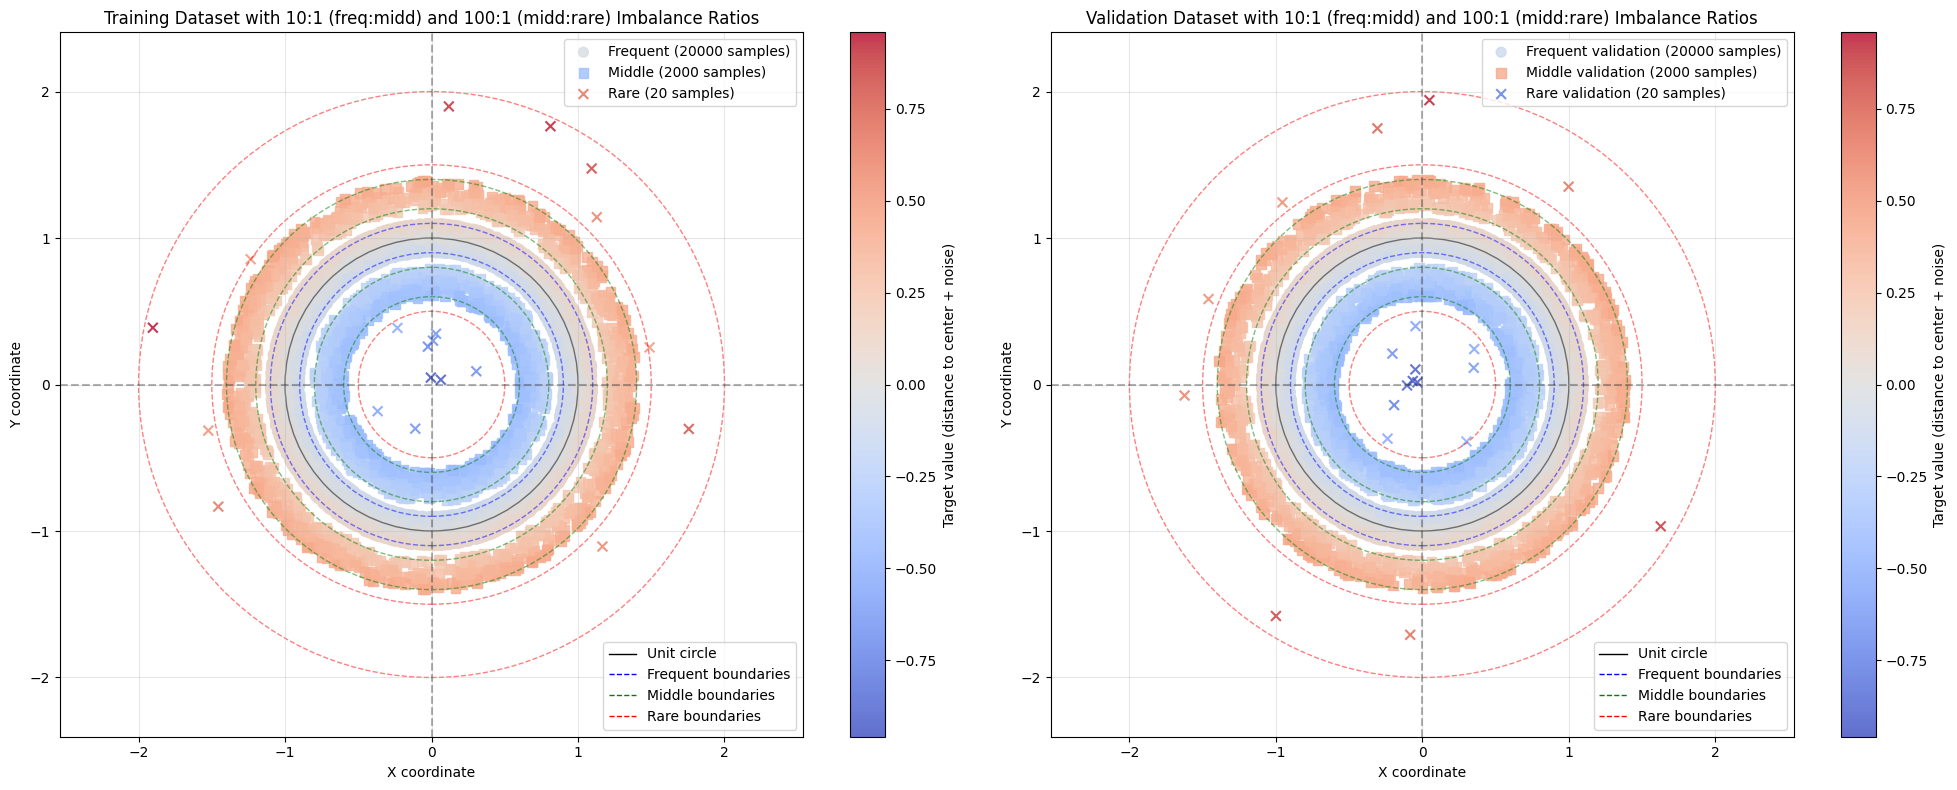

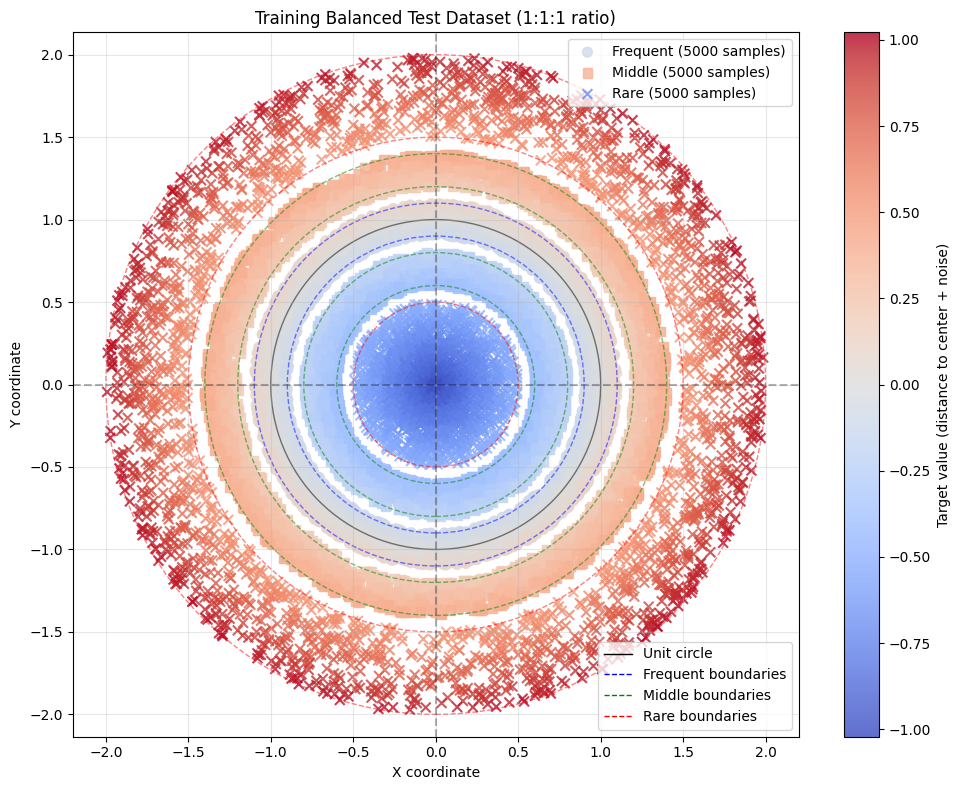

In [17]:
# Run a test with imbalance ratios and plot the results including cosine similarity
# NOTE: 1000:1 IMBALANCED - NO IMPORTANCE WEIGHTING - ADJUSTED GRADIENTS - NO CHECKING FOR CONFLICTS
imb_ratio_freq_midd = 10  # Ratio between frequent and middle samples
imb_ratio_midd_rare = 100   # Ratio between middle and rare samples
# resulting in Ratio between frequent and rare of 1000:1
set_all_seeds(seed=123)

# Test with specific imbalance ratios
X_train, y_train, sample_weights_train = dataset.get_dataset(
    imbalance_ratio_freq_midd=imb_ratio_freq_midd,
    imbalance_ratio_midd_rare=imb_ratio_midd_rare
)
X_val, y_val, sample_weights_val = dataset.get_val_dataset(
    imbalance_ratio_freq_midd=imb_ratio_freq_midd,
    imbalance_ratio_midd_rare=imb_ratio_midd_rare
)

# Plot dataset
plot_dataset(
    dataset=dataset,
    X=X_train, 
    y=y_train, 
    X_val=X_val, 
    y_val=y_val,
    title=f"Dataset with {imb_ratio_freq_midd}:1 (freq:midd) and {imb_ratio_midd_rare}:1 (midd:rare) Imbalance Ratios",
    draw_circles=True,
    debug=False
)

# Plot balanced test dataset
plot_dataset(
    dataset=test_dataset,
    X=X_test, 
    y=y_test, 
    title="Balanced Test Dataset (1:1:1 ratio)",
    draw_circles=True,
    debug=False
)


In [18]:

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model(weight_decay=weight_decay)

# Use updated beta parameter for gradient adjustment
beta_strategy = 'idea1'  # Try different strategies: 'idea1', 'idea2', 'idea12', 'interpolate'
check_conflicts = False
adjust_gradients = False # vanilla


# Train with dataset object so gradient cosine similarity can be calculated
history = train_model(
    model=model, 
    dataset=dataset,
    X_train=X_train, 
    y_train=y_train, 
    X_val=X_val, 
    y_val=y_val, 
    sample_weights_train=None,
    sample_weights_val=None,
    epochs= epochs, 
    batch_size=100, 
    lr=lr,
    adjust_gradients=adjust_gradients,
    grad_adjust_beta=beta_strategy,  # Using the beta strategy
    check_conflicts=check_conflicts,
    debug=False
)  

# Plot training results
plot_training_curves(history)

# Plot all gradient cosine similarities in one figure
plot_all_grad_cos_sims(
    history=history, 
    imb_ratio_freq_midd=imb_ratio_freq_midd,
    imb_ratio_midd_rare=imb_ratio_midd_rare,
    trend=False,
    y_limit=1.1
)

# Evaluate on balanced test set
test_results = report_performance(
    model, 
    test_dataset,  # Balanced test dataset
    X_test, y_test
)

# Save the model performance metrics for later comparison
performance_summary = {
    'beta_strategy': beta_strategy,
    'check_conflicts': check_conflicts,
    'imb_ratio_freq_midd': imb_ratio_freq_midd,
    'imb_ratio_midd_rare': imb_ratio_midd_rare,
    'test_mae': test_results,
}


Training model with 22020 training samples and 22020 validation samples


UnimplementedError: {{function_node __wrapped__UnsortedSegmentSum_device_/job:localhost/replica:0/task:0/device:GPU:0}} Deterministic GPU implementation of unsorted segment reduction op not available. [Op:UnsortedSegmentSum]